ref: https://morris-lab.github.io/CellOracle.documentation/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.html

# Import libraries

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [3]:
sc.settings.set_figure_params(dpi=120)

# Load gene-expression data

In [4]:
# read in adata
# whole data
adata = sc.read_h5ad('/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA/aCMs_WholeSample_paired_with_time.h5ad')
adata

AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'
    uns: 'donor_colors', 'fine_grain_colors', 'graph', 'milesto

In [5]:
print(adata.X.data[:5])
adata.var['modality'].value_counts()

[2. 1. 1. 1. 1.]


Peaks              508040
Gene Expression     36601
Name: modality, dtype: int64

In [6]:
# subset gene expression data
adata = adata[:,adata.var['modality']=='Gene Expression']

# keep raw cont data before log normalisation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

# filter and log-normalise
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print(adata.X.data[:10])
adata

[1.559231  1.0569503 1.0569503 1.0569503 1.0569503 1.0569503 2.7738788
 1.559231  1.0569503 1.0569503]


AnnData object with n_obs × n_vars = 5664 × 23953
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: 'donor_colors', 'fine_grain_colors', 'graph'

In [7]:
# select genes which are targeted or the regulators in the regulons
# 
ereg_signatures = utils.read_pkl("/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/aCM_n570_Gene_eRegulon_signatures.pkl")
genes_sel = []
for key,value in ereg_signatures.items():
    genes_sel = genes_sel + value
    genes_sel = genes_sel + [key.split('_')[0]]
genes_sel = list(set(genes_sel))

# hvg and targeted
# hvg_targeted = list(set(adata.var_names[adata.var.highly_variable]).intersection(genes_targeted))
# len(hvg_targeted)
len(genes_sel)

10870

In [8]:
# subset genes
# adata = adata[:,hvg_targeted]
adata = adata[:,genes_sel]
adata

View of AnnData object with n_obs × n_vars = 5664 × 10870
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: 'donor_colors', 'fine_grain_colors',

In [9]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :5664
Gene number is :10870


In [10]:
# add t_binned category
n_bin_time = 3
adata.obs['t_binned'] = pd.cut(adata.obs['t'],
                               bins=n_bin_time,
                               labels=[f't{str(x+1)}' for x in range(n_bin_time)])
print(set(adata.obs['t_binned']))

# combine fine_grain and t_binned category
adata.obs['fine_grain_time-binned'] = adata.obs['fine_grain'].astype('str')+'_'+adata.obs['t_binned'].astype('str')

/tmp/ipykernel_3282310/3161589083.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['t_binned'] = pd.cut(adata.obs['t'],


{'t1', 't2', 't3'}


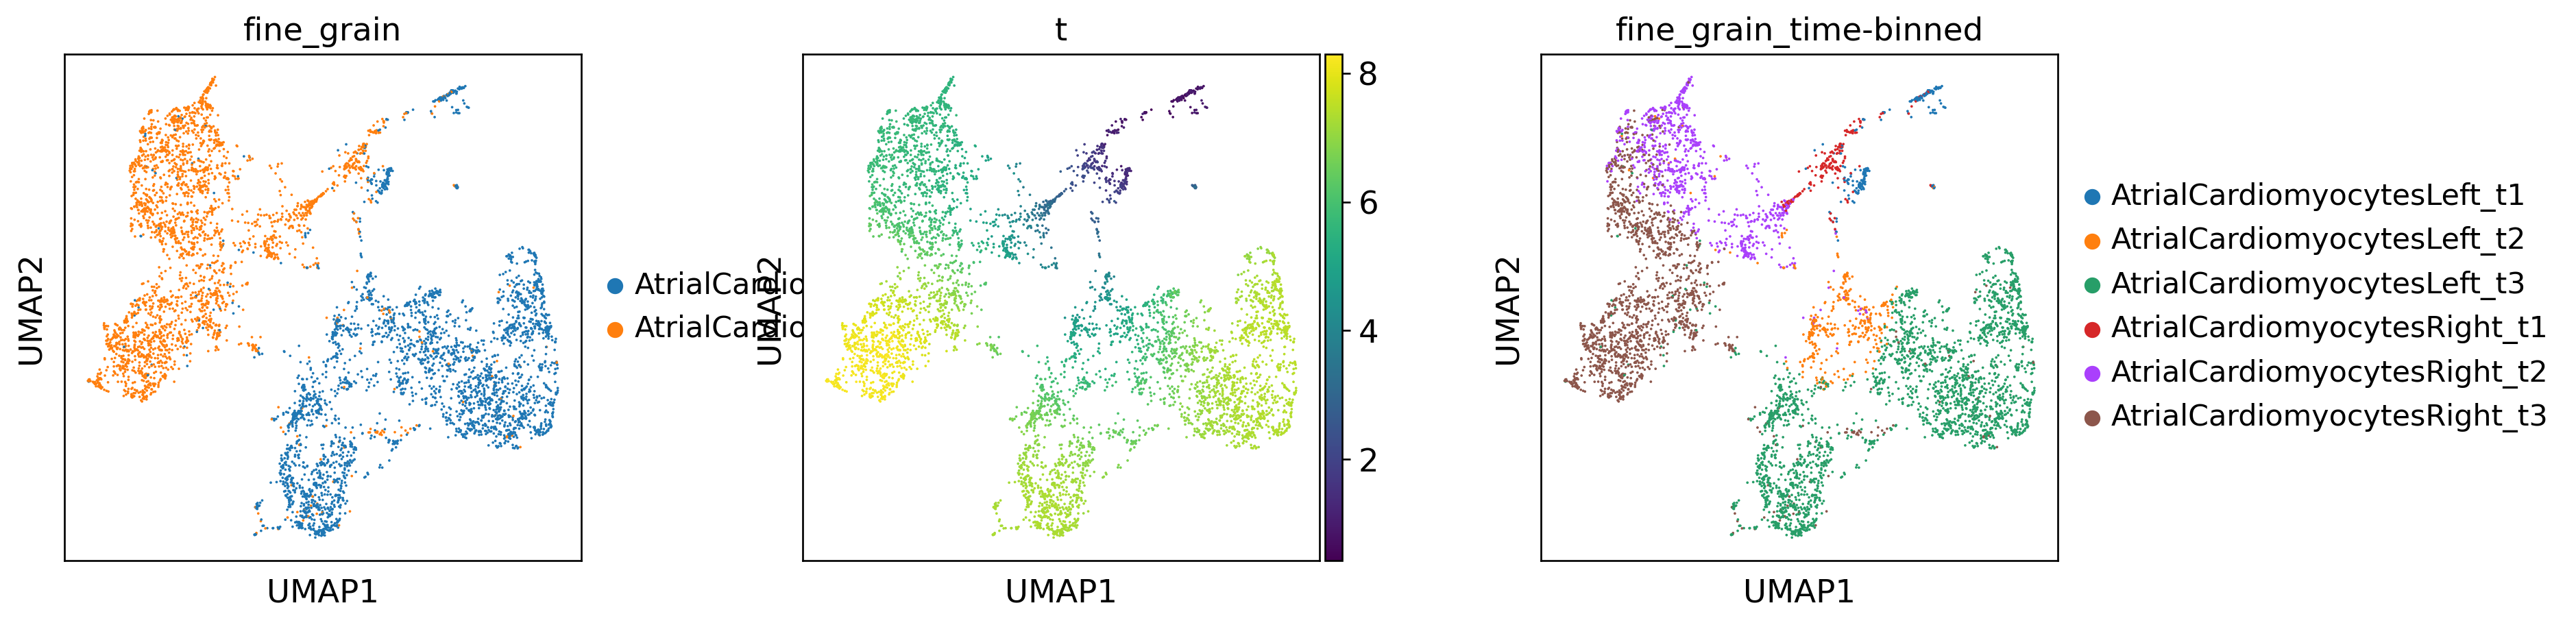

In [11]:
sc.pl.umap(adata,color=['fine_grain','t','fine_grain_time-binned'], size=5, wspace=0.3, ncols=3)

# Make oracle object

In [13]:
import celloracle as co
co.__version__

2025-05-05 21:07:46,185 - INFO - BioProspector no longer found.
2025-05-05 21:07:46,186 - INFO - HMS no longer found.
2025-05-05 21:07:46,188 - INFO - MDmodule no longer found.
2025-05-05 21:07:46,189 - INFO - Posmo no longer found.
2025-05-05 21:07:46,194 - INFO - Using included version of BioProspector.
2025-05-05 21:07:46,198 - INFO - Using included version of HMS.
2025-05-05 21:07:46,202 - INFO - Using included version of MDmodule.
2025-05-05 21:07:46,205 - INFO - Using included version of Posmo.
2025-05-05 21:07:46,211 - INFO - Configuration file: /nfs/users/nfs_k/kk18/.config/gimmemotifs/gimmemotifs.cfg


'0.20.0'

In [14]:
# Instantiate Oracle object
oracle = co.Oracle()

In [15]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones', 't_binned', 'fine_grain_time-binned']
Dimensional reduction:  ['X_R', 'X_multiVI', 'X_umap']


In [16]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="fine_grain_time-binned",
                                   embedding_name="X_umap")

10870 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


# Add scenicplus base GRN

In [17]:
# read in scenicplus regulons
regulons = utils.read_pkl('/nfs/team205/heart/pyscenic/plus/baseGRN_forCO/AtrialCM_baseGRN_act.pkl')
TG_to_TF_dictionary = co.utility.inverse_dictionary(regulons)

  0%|          | 0/10836 [00:00<?, ?it/s]

In [18]:
# add
oracle.import_TF_data(TFdict=TG_to_TF_dictionary)

In [19]:
TG_to_TF_dictionary['SGSM2']

['KLF13', 'KLF15', 'MBD1', 'RELA', 'SREBF1', 'VEZF1', 'ZNF28', 'ZNF644']

# KNN imputation

CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

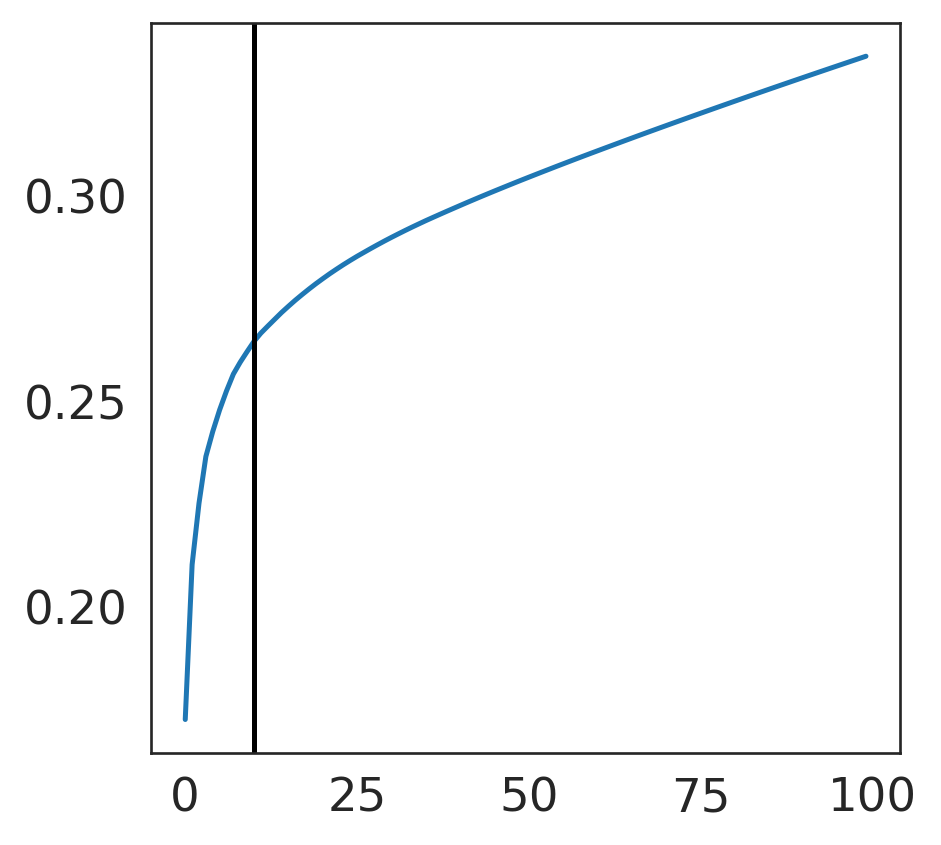

10
CPU times: user 1min 32s, sys: 994 ms, total: 1min 33s
Wall time: 1min 36s


In [20]:
%%time
%matplotlib inline
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [21]:
oracle.pcs.shape

(5664, 5664)

Estimate the optimal number of nearest neighbors for KNN imputation.

In [22]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :5664


In [23]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :141


In [24]:
%%time
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

CPU times: user 8.42 s, sys: 1.53 s, total: 9.94 s
Wall time: 10.2 s


In [25]:
# Save oracle object.
oracle.to_hdf5("/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM.celloracle.oracle")

In [ ]:
# Load
oracle = co.load_hdf5("/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM.celloracle.oracle")

# GRN calculation

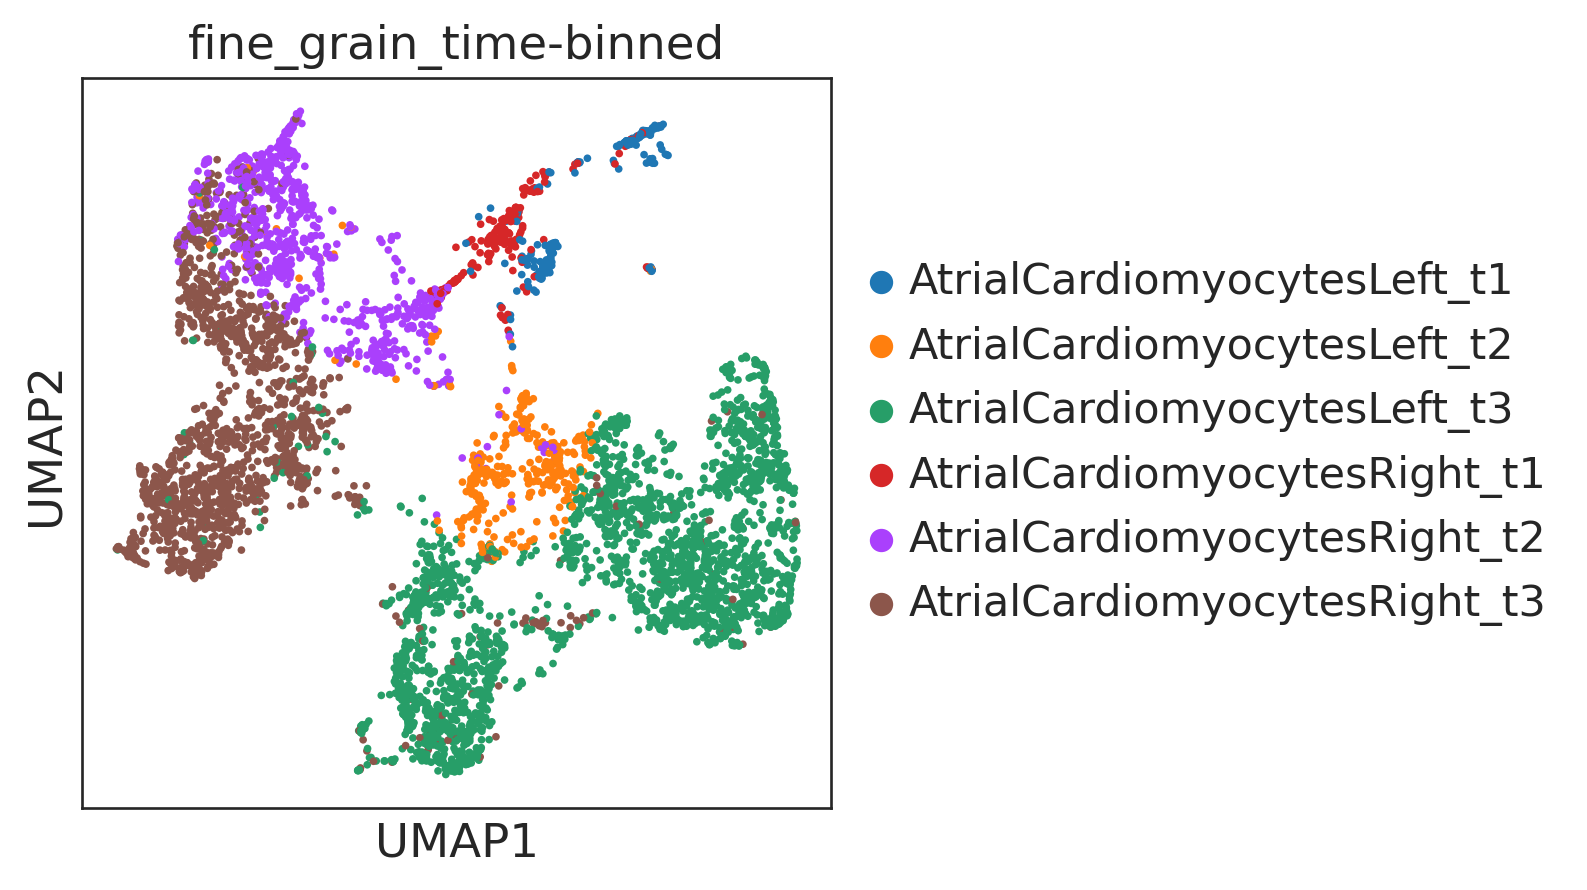

In [26]:
%matplotlib inline
# Check clustering data
sc.pl.umap(oracle.adata, color='fine_grain_time-binned')

In [27]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit='fine_grain_time-binned', alpha=10,
                         verbose_level=10)

  0%|          | 0/6 [00:00<?, ?it/s]

Inferring GRN for AtrialCardiomyocytesLeft_t1...


  0%|          | 0/10836 [00:00<?, ?it/s]

Inferring GRN for AtrialCardiomyocytesLeft_t2...


  0%|          | 0/10836 [00:00<?, ?it/s]

Inferring GRN for AtrialCardiomyocytesLeft_t3...


  0%|          | 0/10836 [00:00<?, ?it/s]

Inferring GRN for AtrialCardiomyocytesRight_t1...


  0%|          | 0/10836 [00:00<?, ?it/s]

Inferring GRN for AtrialCardiomyocytesRight_t2...


  0%|          | 0/10836 [00:00<?, ?it/s]

Inferring GRN for AtrialCardiomyocytesRight_t3...


  0%|          | 0/10836 [00:00<?, ?it/s]

CPU times: user 54min 47s, sys: 12.5 s, total: 55min
Wall time: 56min 58s


In [28]:
links.links_dict.keys()

dict_keys(['AtrialCardiomyocytesLeft_t1', 'AtrialCardiomyocytesLeft_t2', 'AtrialCardiomyocytesLeft_t3', 'AtrialCardiomyocytesRight_t1', 'AtrialCardiomyocytesRight_t2', 'AtrialCardiomyocytesRight_t3'])

In [30]:
links.links_dict['AtrialCardiomyocytesRight_t3']

source target  coef_mean  coef_abs             p      -logp
0       NFE2L1    A2M   0.046020  0.046020  3.582132e-04   3.445858
1         NFYC    A2M  -0.023543  0.023543  4.421299e-03   2.354450
2         TFEB    A2M   0.021793  0.021793  1.861977e-05   4.730026
3      CREB3L2    A2M   0.013049  0.013049  3.160941e-02   1.500184
4         MBD2    A2M  -0.004803  0.004803  8.690188e-02   1.060971
...        ...    ...        ...       ...           ...        ...
59517      SP1    ZYX   0.016459  0.016459  3.573357e-15  14.446924
59518     NFIC  ZZEF1   0.040532  0.040532  1.780297e-10   9.749508
59519      SP4  ZZEF1   0.008537  0.008537  8.588767e-03   2.066069
59520   ZNF148  ZZEF1   0.070796  0.070796  2.470330e-17  16.607245
59521    MEF2A  ZZEF1   0.023548  0.023548  3.060601e-07   6.514193

[59522 rows x 6 columns]

In [29]:
# Save Links object.
links.to_hdf5(file_path="/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM_links.celloracle.links")

In [ ]:
# load the saved links
links = co.load_hdf5("/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM_links.celloracle.links")

# Network preprocessing for perturbation simulation

In [31]:
%%time

links.filter_links(p=0.001, weight="coef_abs", threshold_number=10000)

# Calculate network scores.
links.get_network_score()
display(links.merged_score.head())

# Make predictive modelos for simulation
# Here, we will need to fit the ridge regression models again.
# This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
ZBTB44           17               0.004050          4              0.000953   
KCNH7             3               0.000715          3              0.000715   
BHLHE40          51               0.012149          6              0.001429   
NPPA              3               0.000715          3              0.000715   
VEZF1           116               0.027632          0              0.000000   

         degree_out  degree_centrality_out  betweenness_centrality  \
ZBTB44           13               0.003097                 16370.0   
KCNH7             0               0.000000                     0.0   
BHLHE40          45               0.010719                  2411.0   
NPPA              0               0.000000                     0.0   
VEZF1           116               0.027632                     0.0   

         eigenvector_centrality                      cluster  
ZBTB44                 0.023809  AtrialCardiomyocytesLeft_t1  
KCNH7                  0.005513  AtrialCardiomyocytesLeft_t1  
BHLHE40                0.016328  AtrialCardiomyocytesLeft_t1  
NPPA                   0.002832  AtrialCardiomyocytesLeft_t1  
VEZF1                  0.010920  AtrialCardiomyocytesLeft_t1

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 3min 12s, sys: 3.54 s, total: 3min 15s
Wall time: 3min 21s


# Save the oracle object

In [32]:
oracle.to_hdf5("/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.20.0
    n_cells: 5664
    n_genes: 10870
    cluster_name: fine_grain_time-binned
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 10836 genes
    n_regulatory_in_TFdict: 263 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 263 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 10836 genes
    k_for_knn_imputation: 141
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Done

# Network preprocessing

In [33]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=10000)

In [34]:
plt.rcParams["figure.figsize"] = [7, 3]

AtrialCardiomyocytesLeft_t1


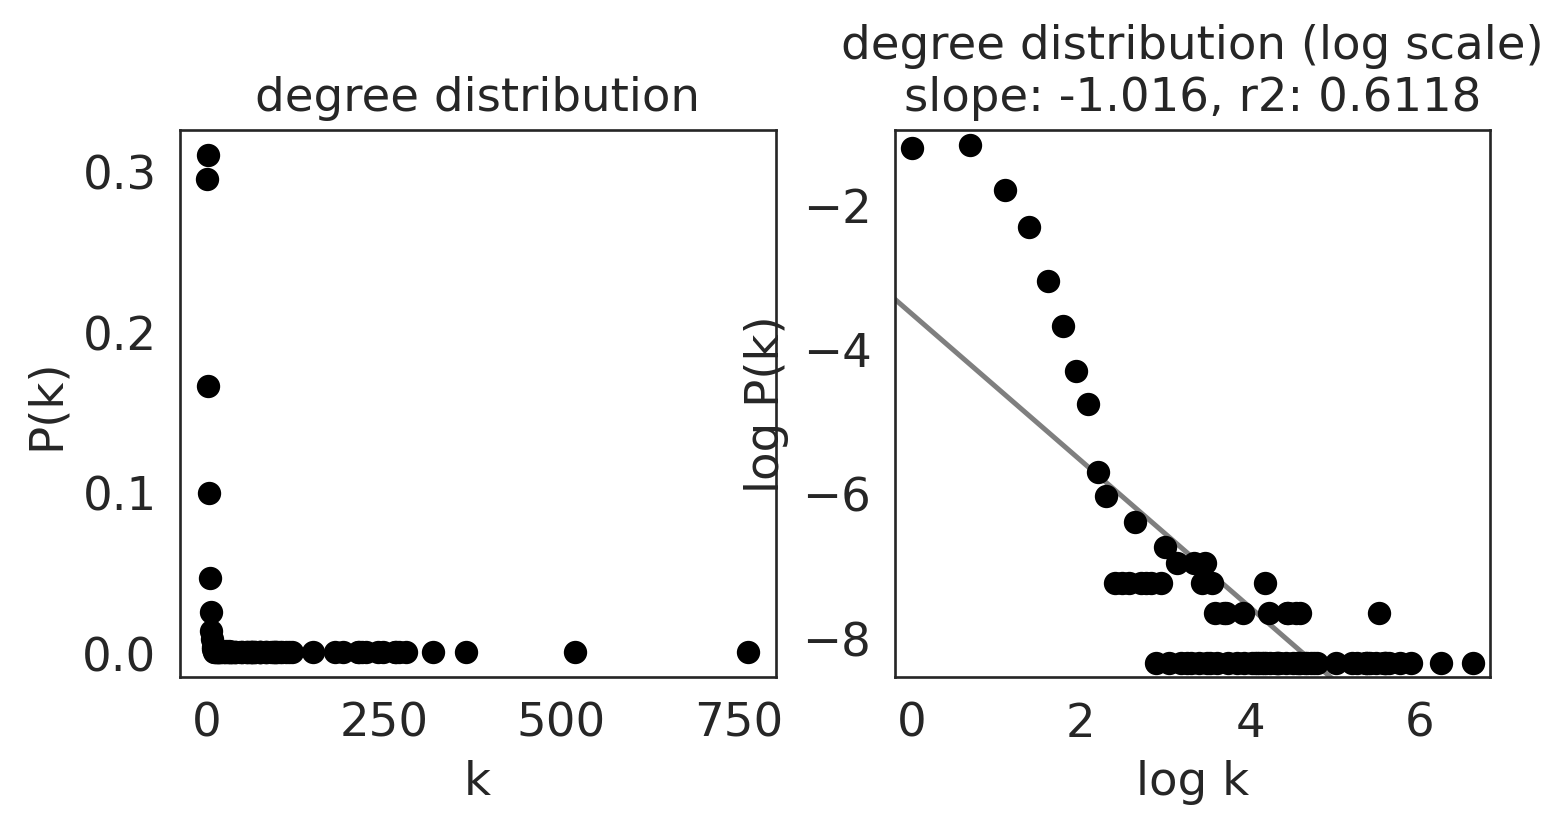

AtrialCardiomyocytesLeft_t2


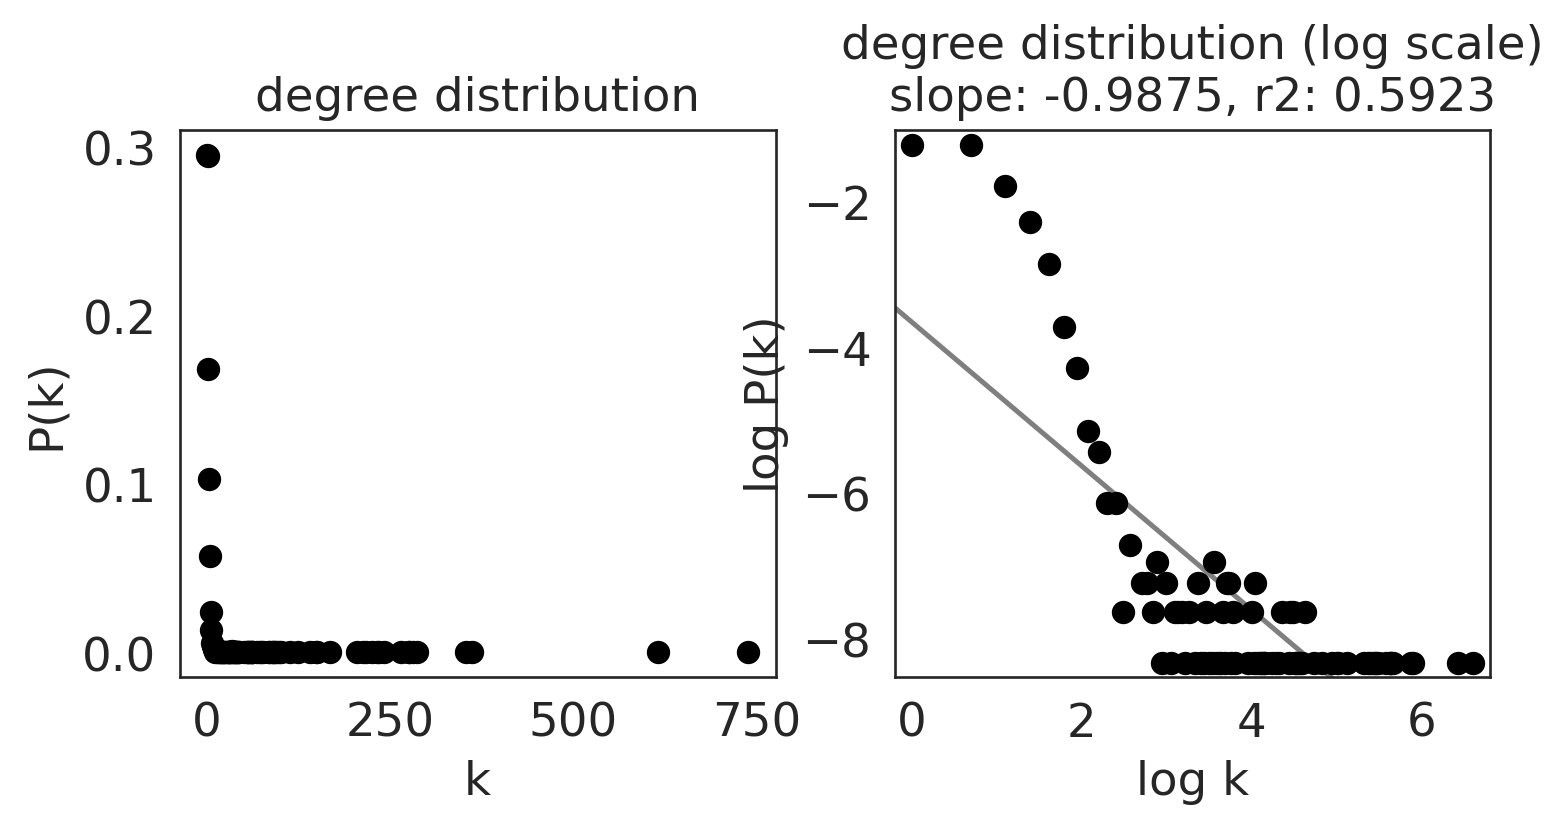

AtrialCardiomyocytesLeft_t3


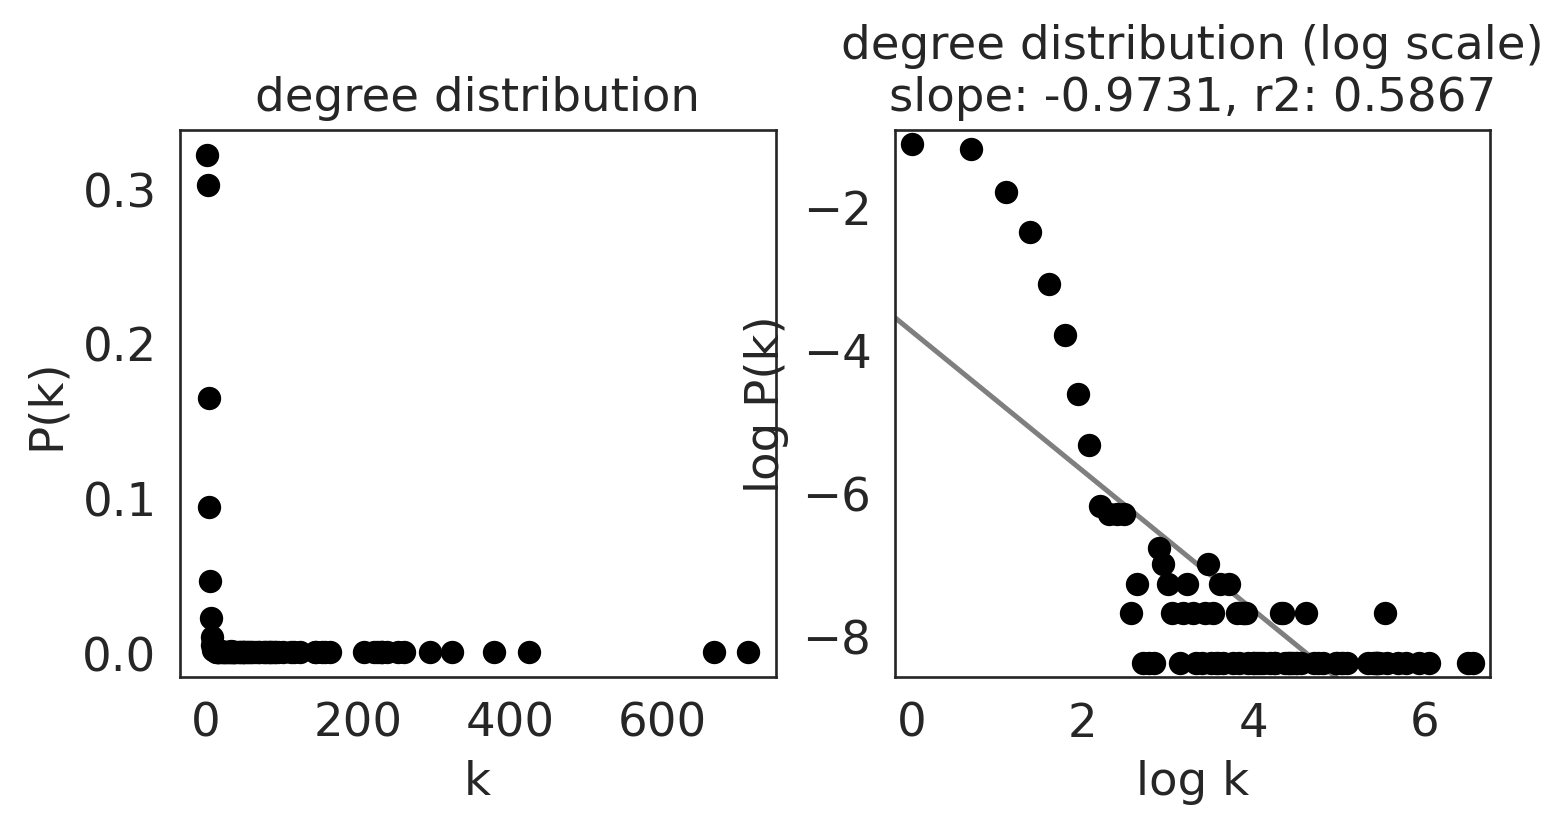

AtrialCardiomyocytesRight_t1


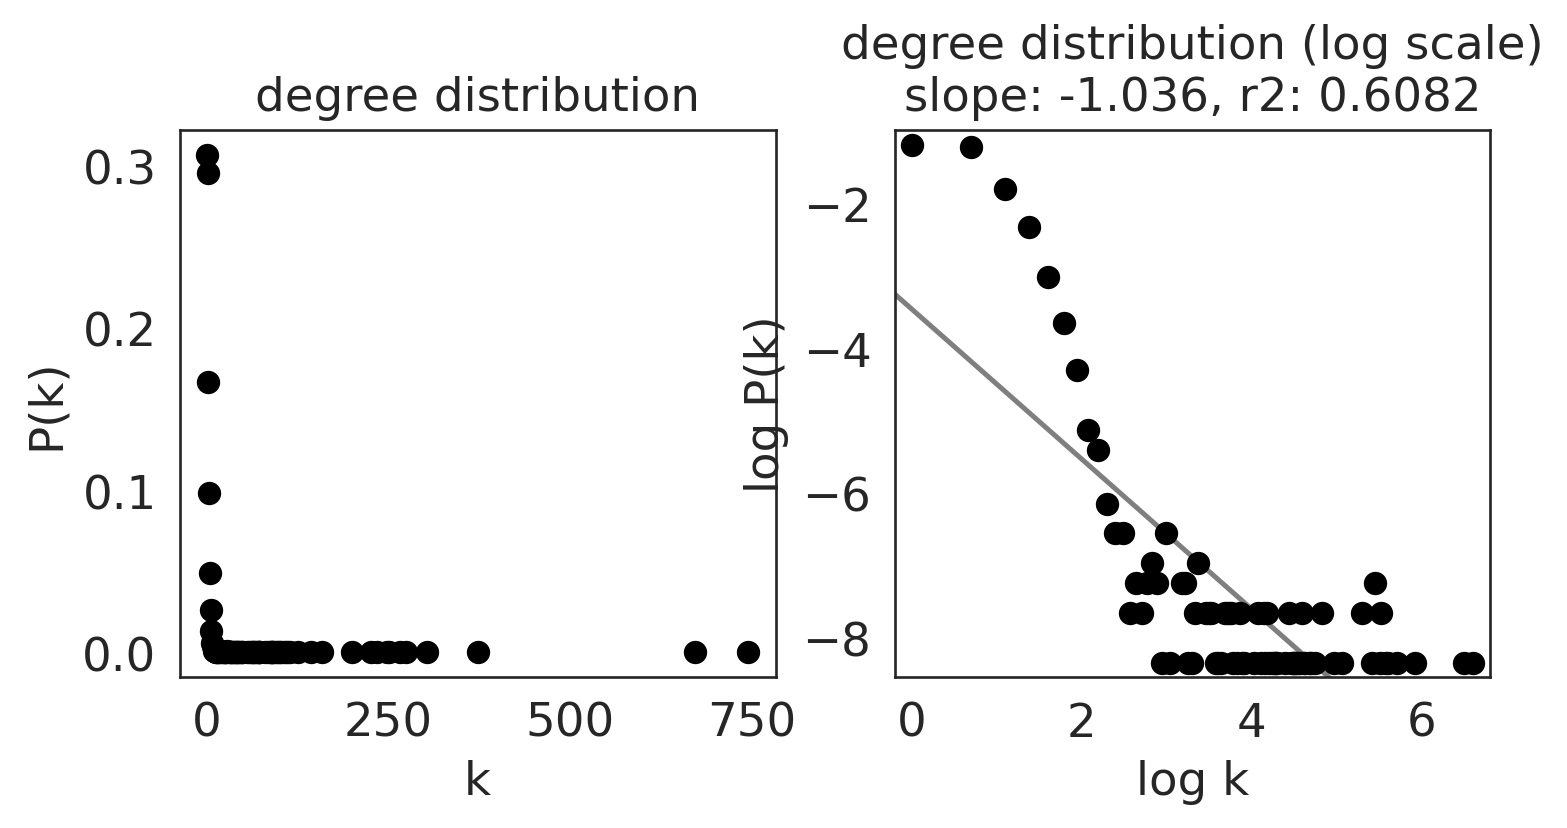

AtrialCardiomyocytesRight_t2


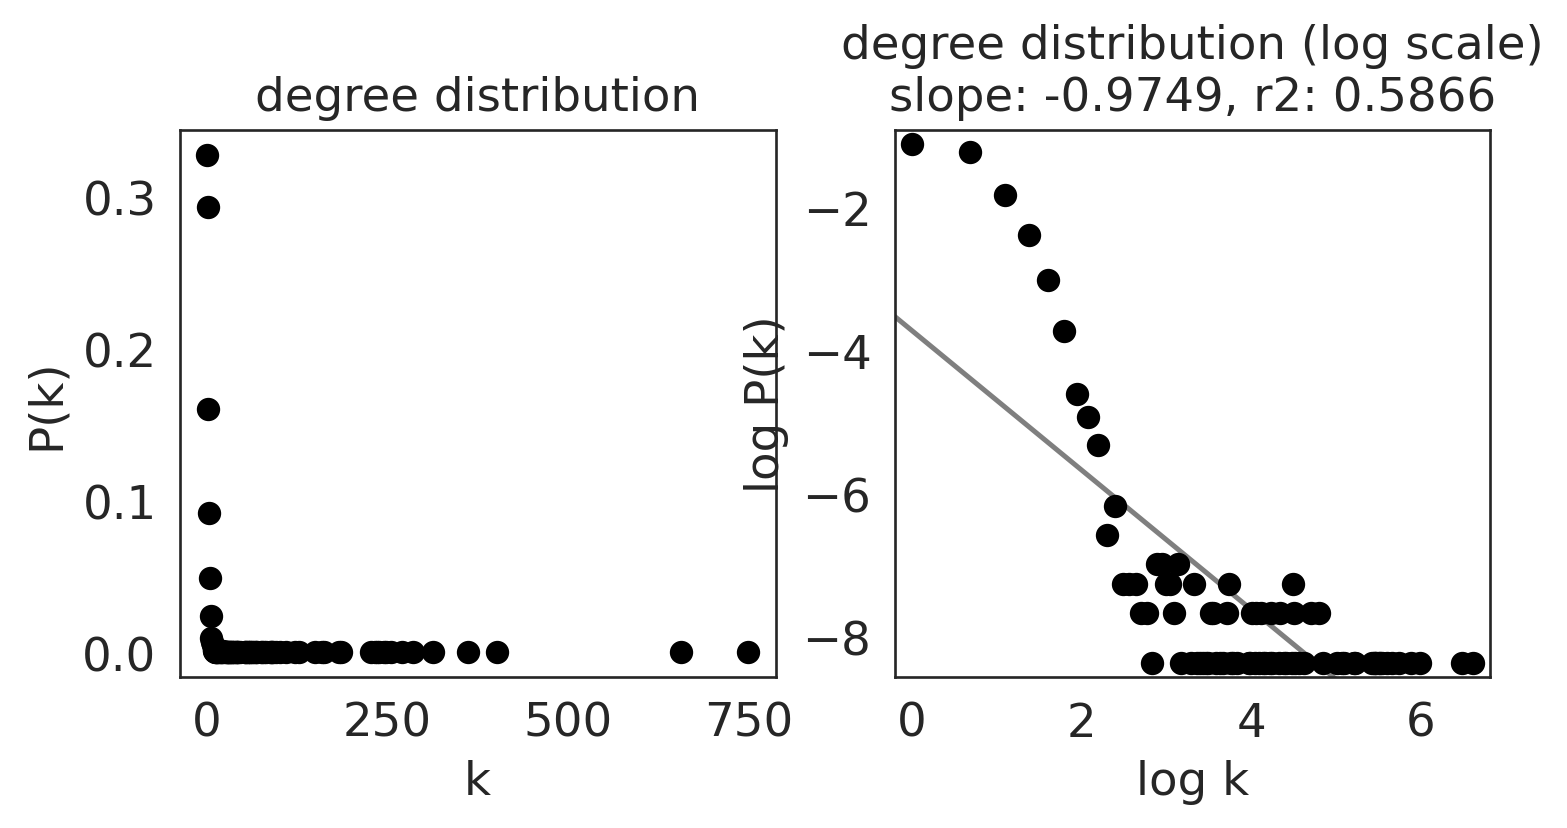

AtrialCardiomyocytesRight_t3


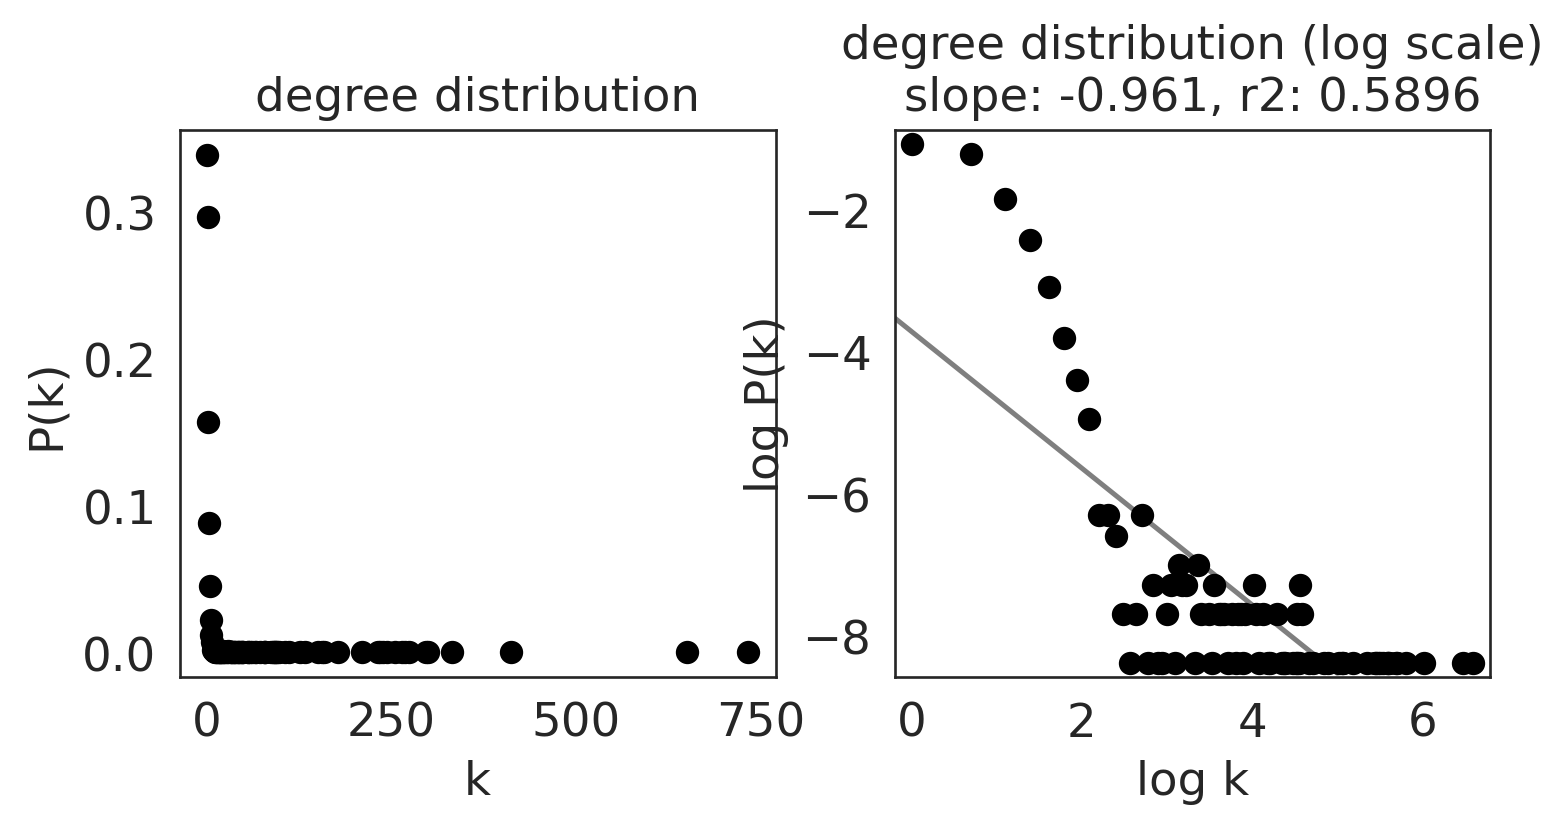

In [35]:
links.plot_degree_distributions(plot_model=True,
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [36]:
# Calculate network scores.
links.get_network_score()

In [37]:
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
ZBTB44           17               0.004050          4              0.000953   
KCNH7             3               0.000715          3              0.000715   
BHLHE40          51               0.012149          6              0.001429   
NPPA              3               0.000715          3              0.000715   
VEZF1           116               0.027632          0              0.000000   

         degree_out  degree_centrality_out  betweenness_centrality  \
ZBTB44           13               0.003097                 16370.0   
KCNH7             0               0.000000                     0.0   
BHLHE40          45               0.010719                  2411.0   
NPPA              0               0.000000                     0.0   
VEZF1           116               0.027632                     0.0   

         eigenvector_centrality                      cluster  
ZBTB44                 0.023809  AtrialCardiomyocytesLeft_t1  
KCNH7                  0.005513  AtrialCardiomyocytesLeft_t1  
BHLHE40                0.016328  AtrialCardiomyocytesLeft_t1  
NPPA                   0.002832  AtrialCardiomyocytesLeft_t1  
VEZF1                  0.010920  AtrialCardiomyocytesLeft_t1

# Network analysis; Network score for each gene

In [38]:
# Check cluster name
links.cluster

['AtrialCardiomyocytesLeft_t1',
 'AtrialCardiomyocytesLeft_t2',
 'AtrialCardiomyocytesLeft_t3',
 'AtrialCardiomyocytesRight_t1',
 'AtrialCardiomyocytesRight_t2',
 'AtrialCardiomyocytesRight_t3']

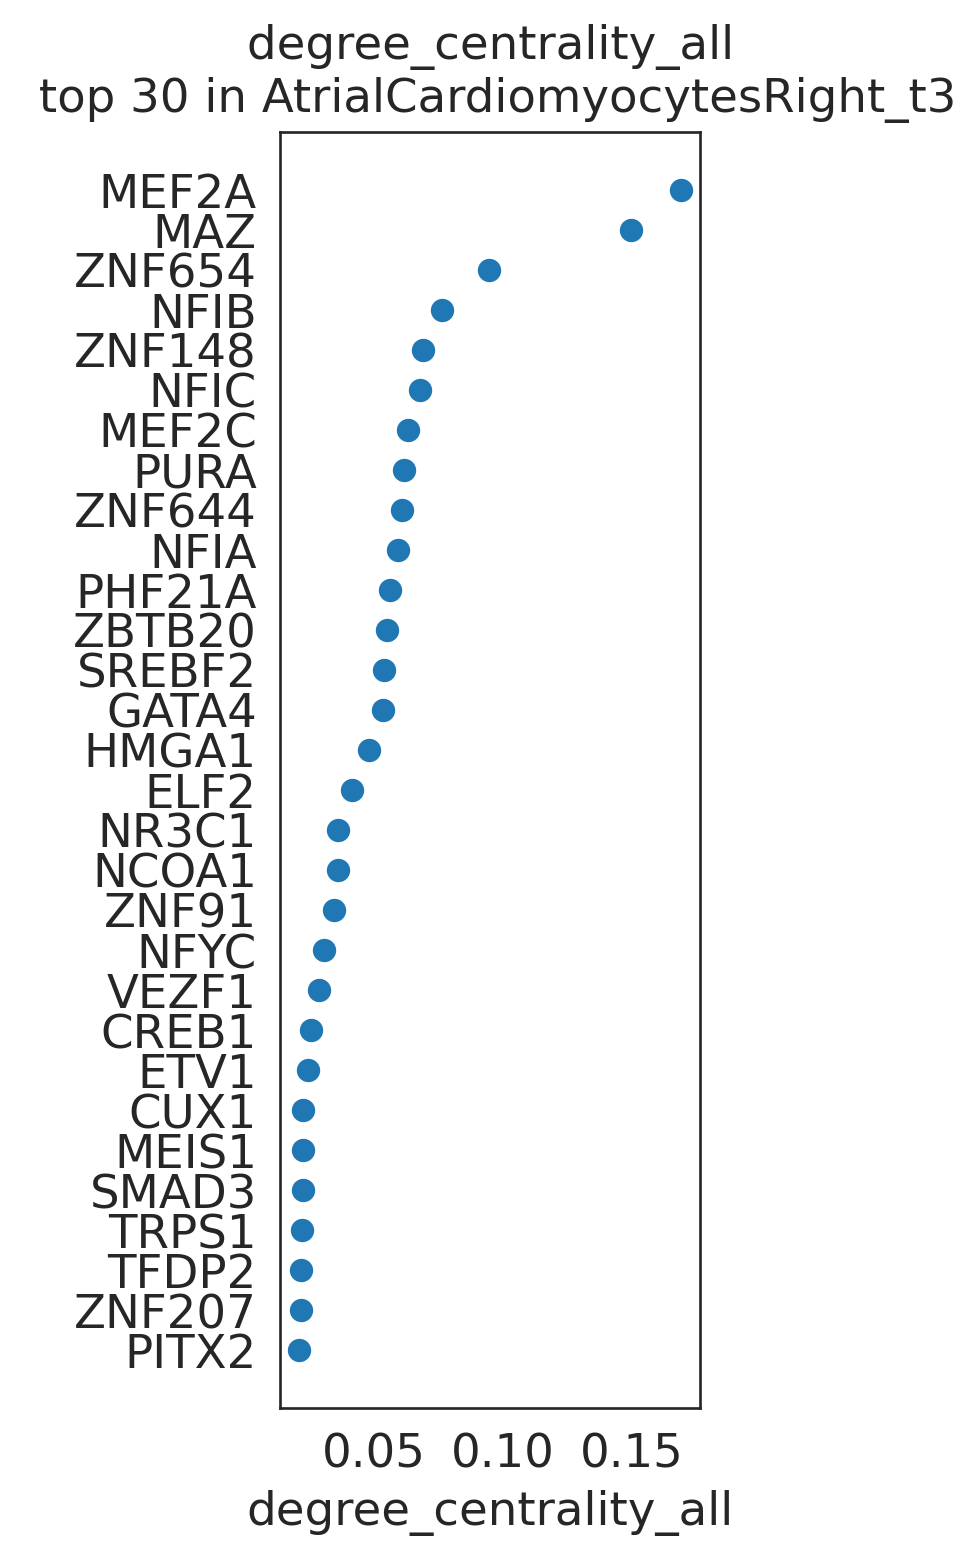

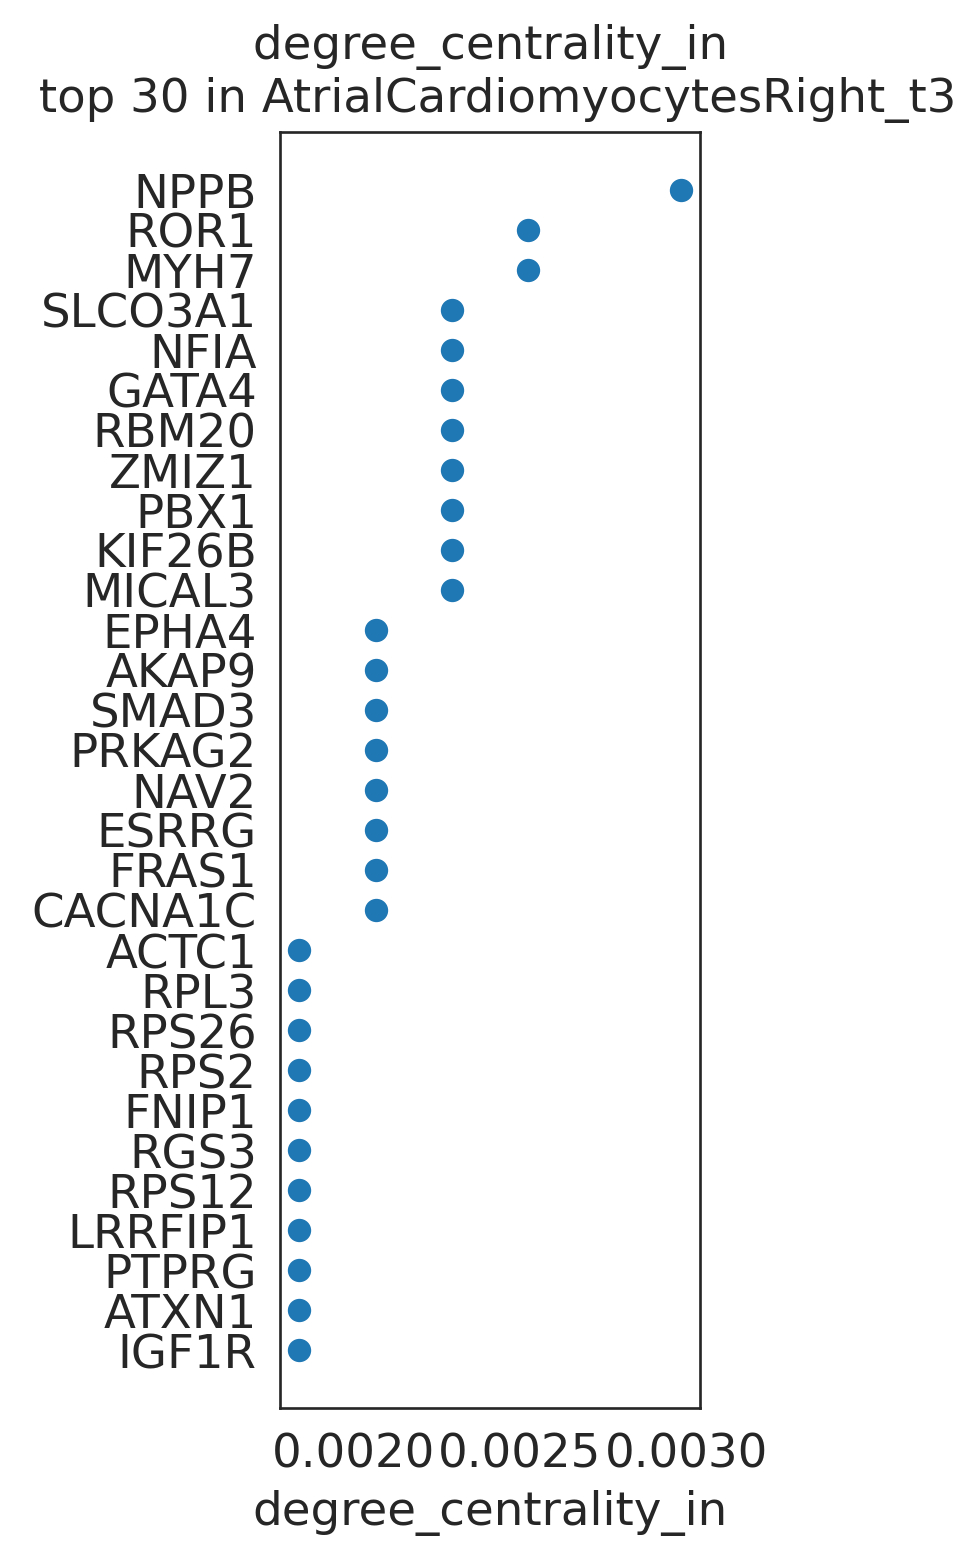

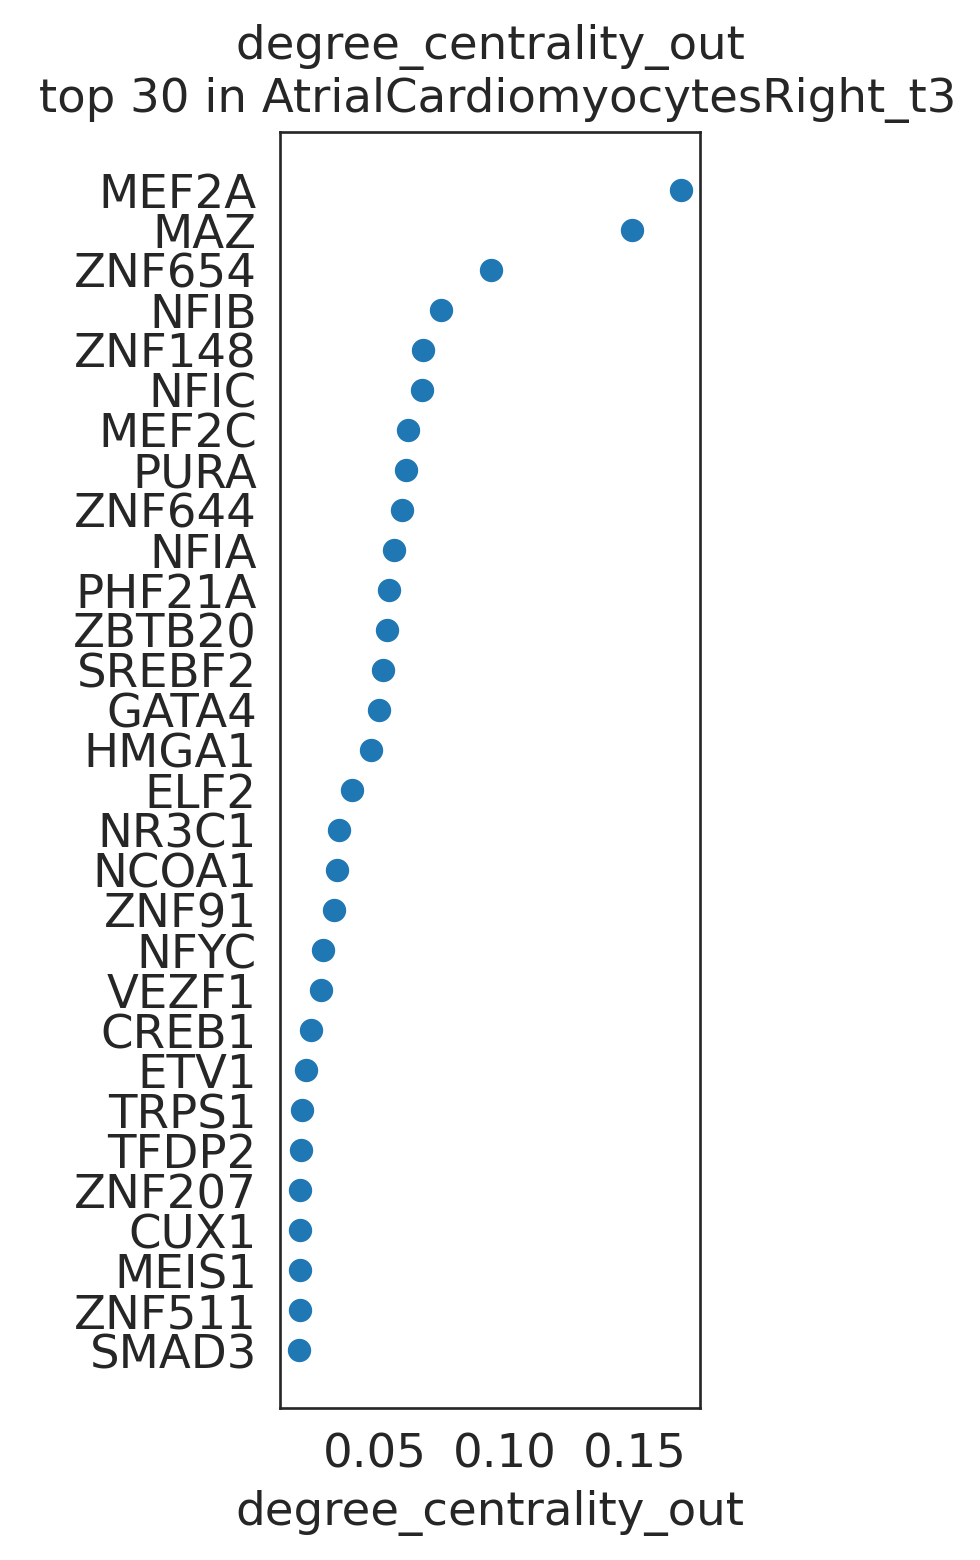

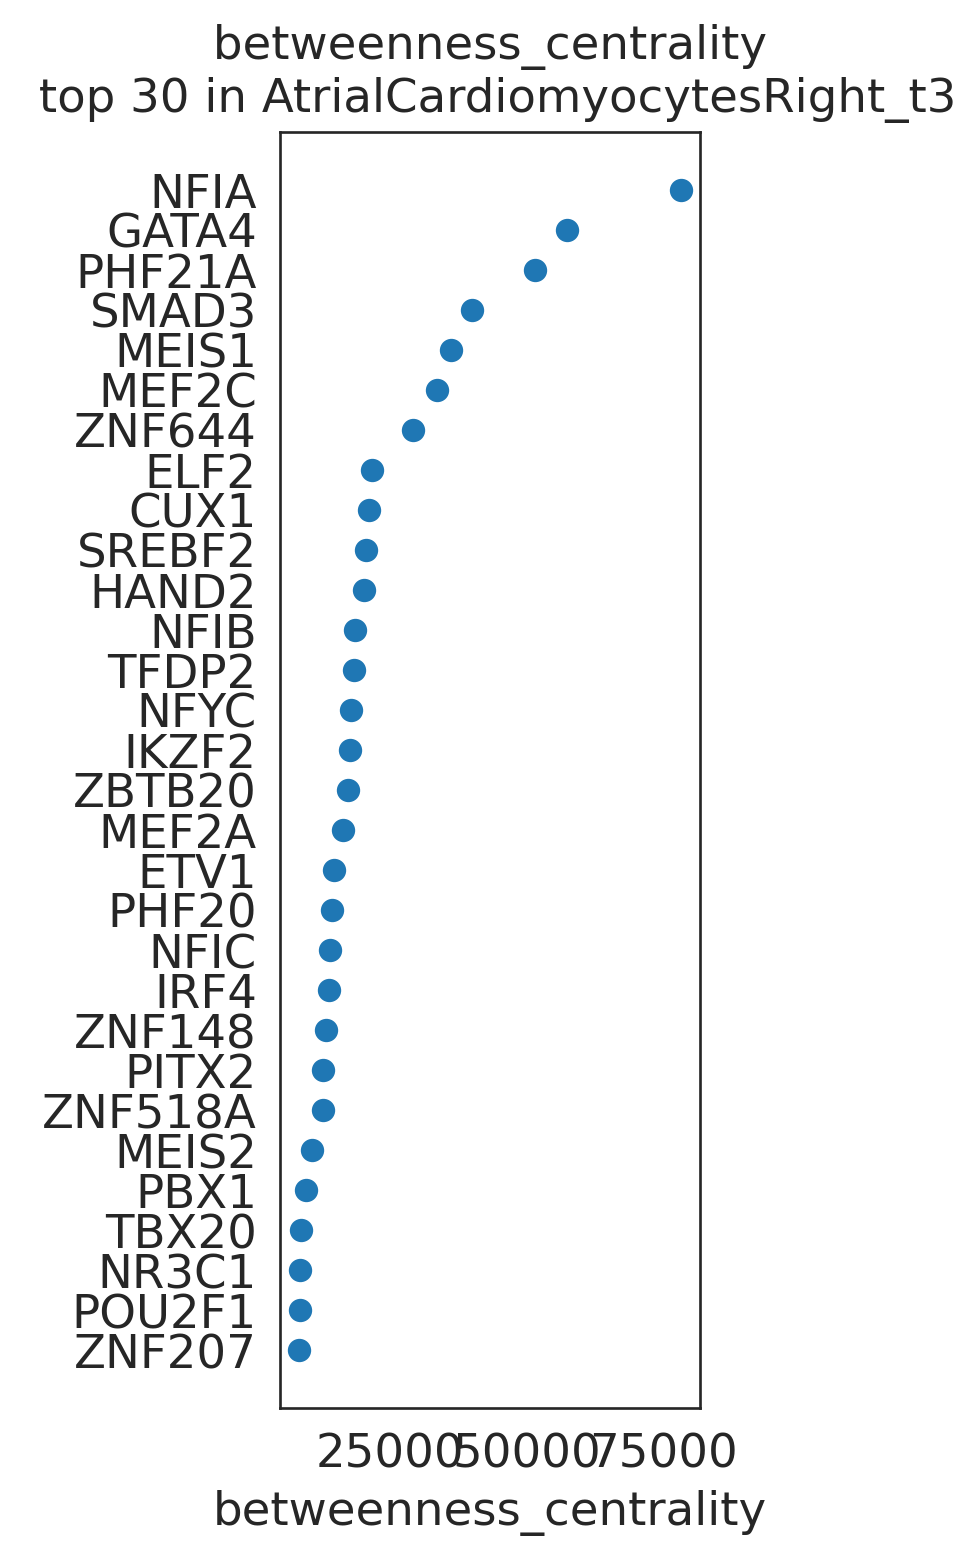

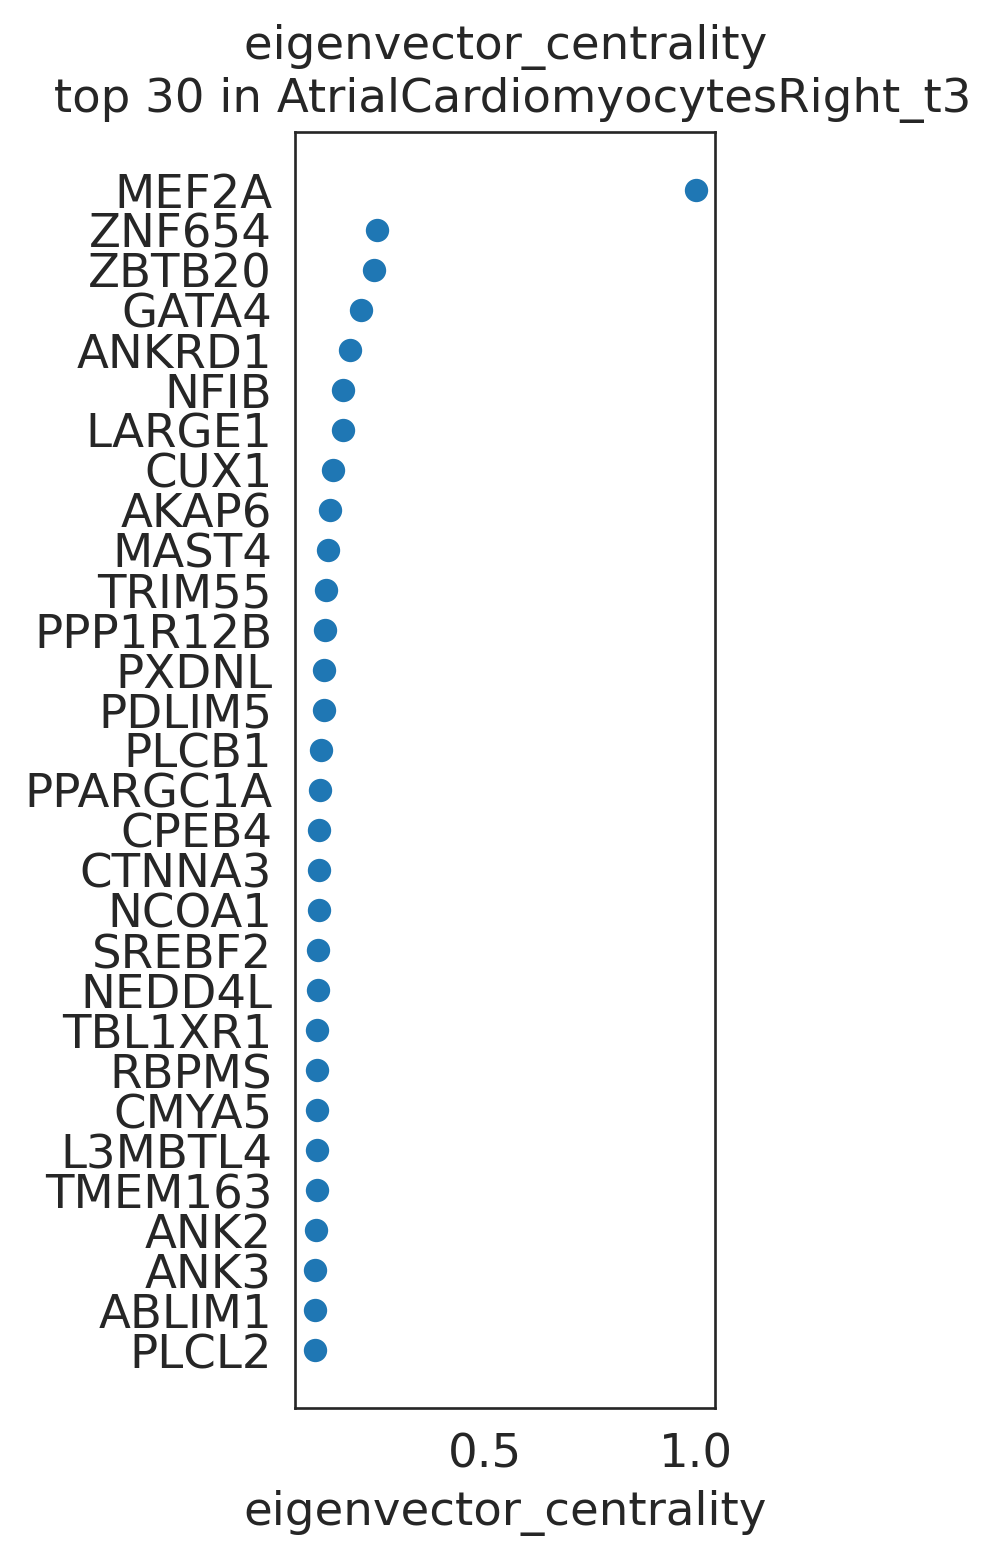

In [39]:
# Visualize top n-th genes with high scores.
plt.rcParams["figure.figsize"] = [5, 7]
links.plot_scores_as_rank(cluster='AtrialCardiomyocytesRight_t3', n_gene=30, save=None)

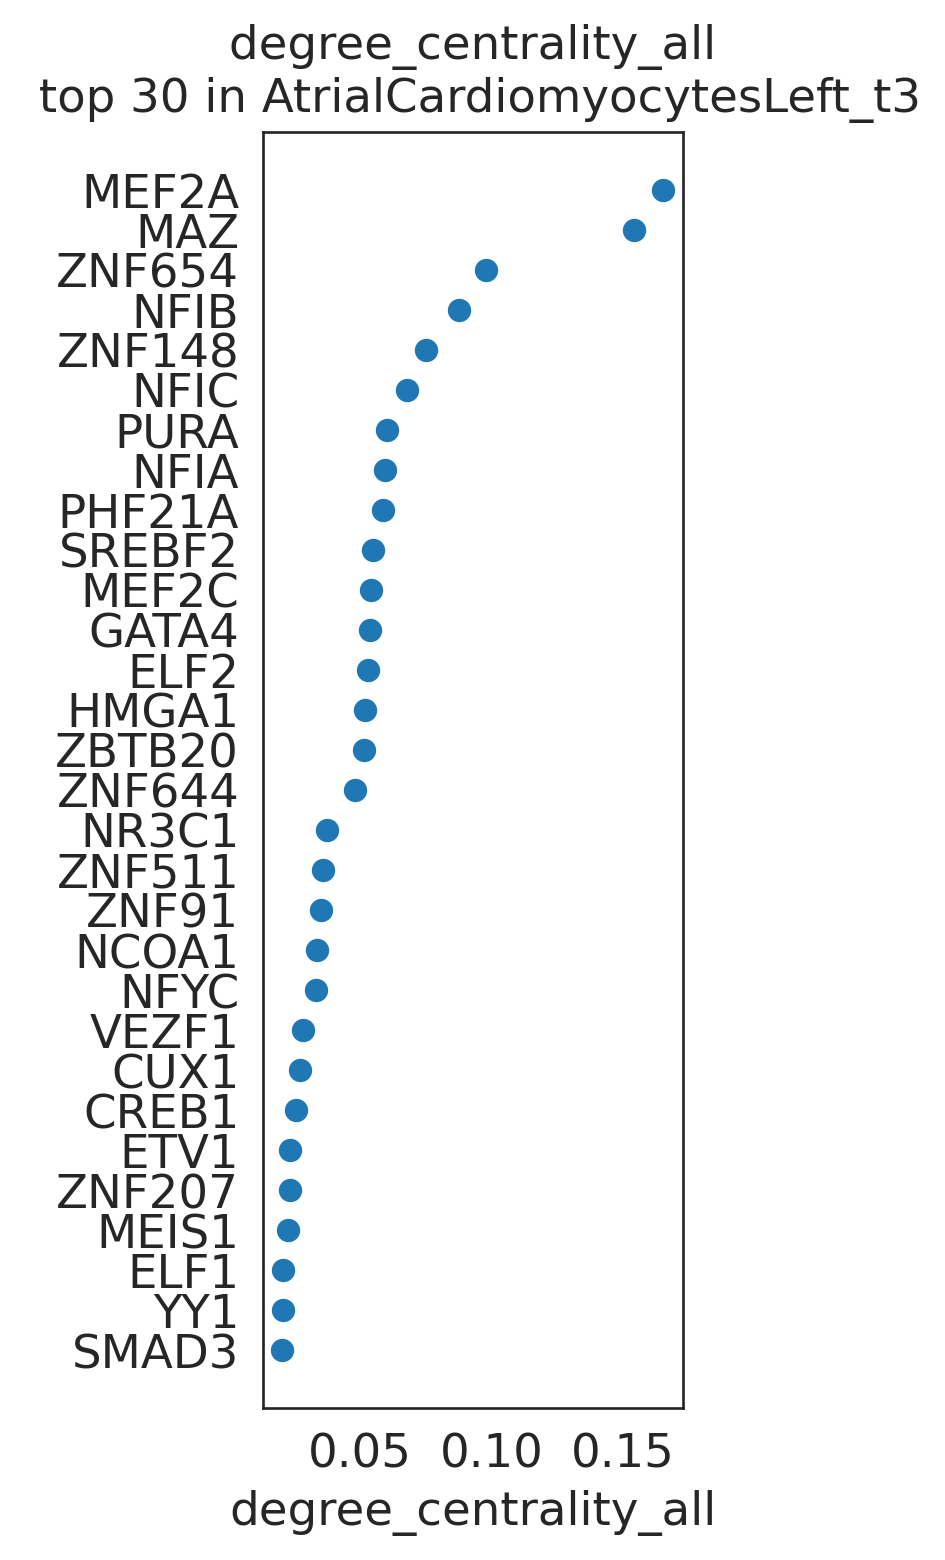

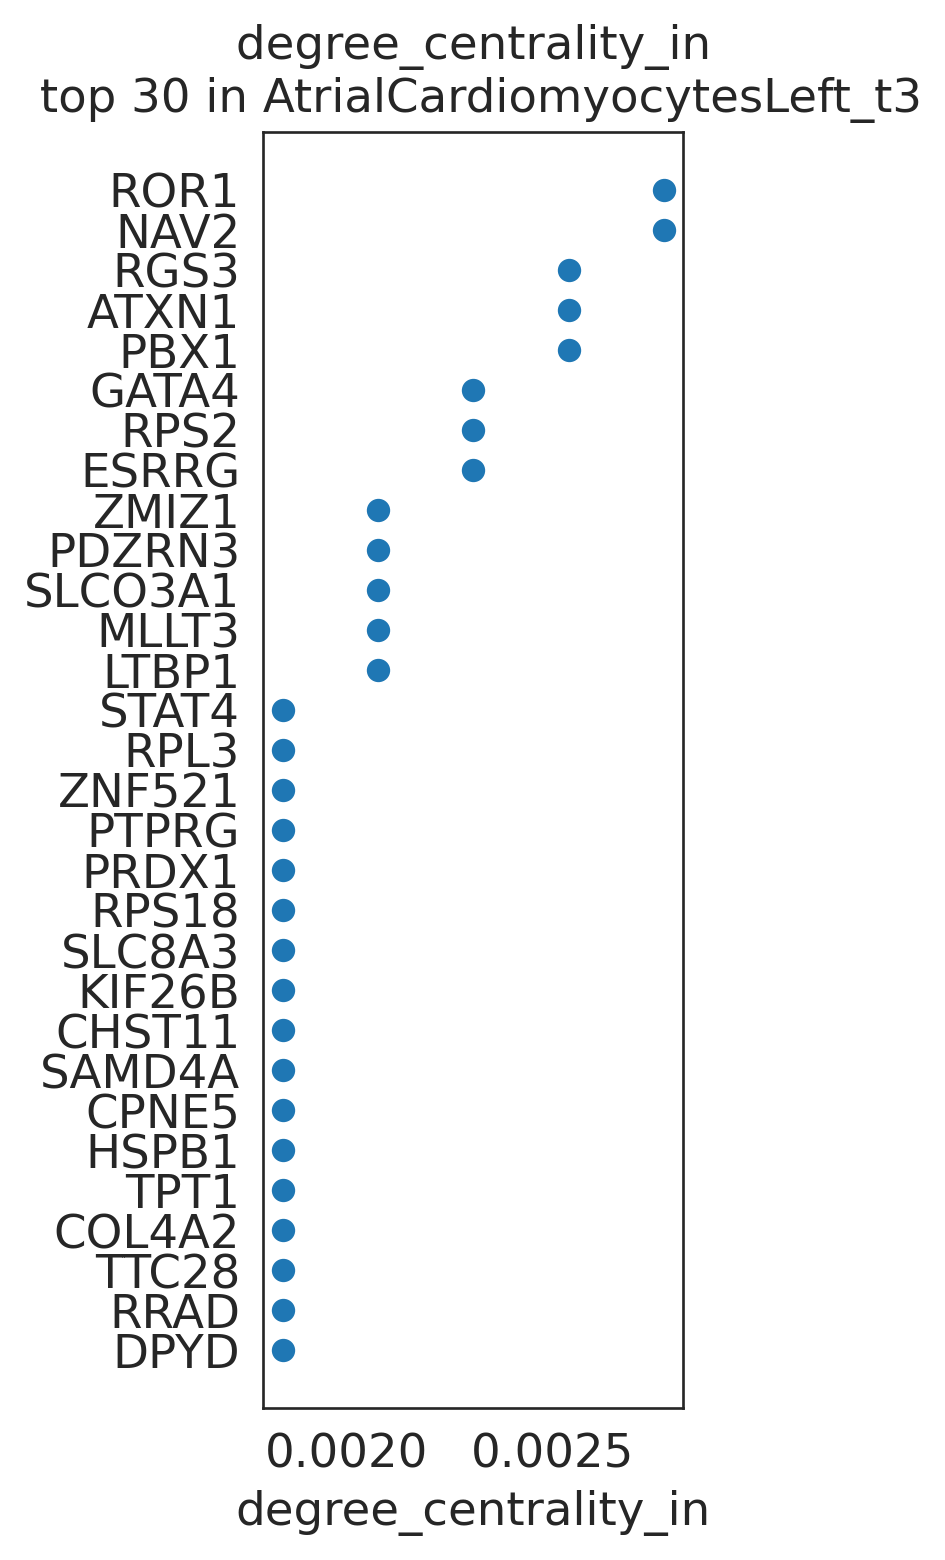

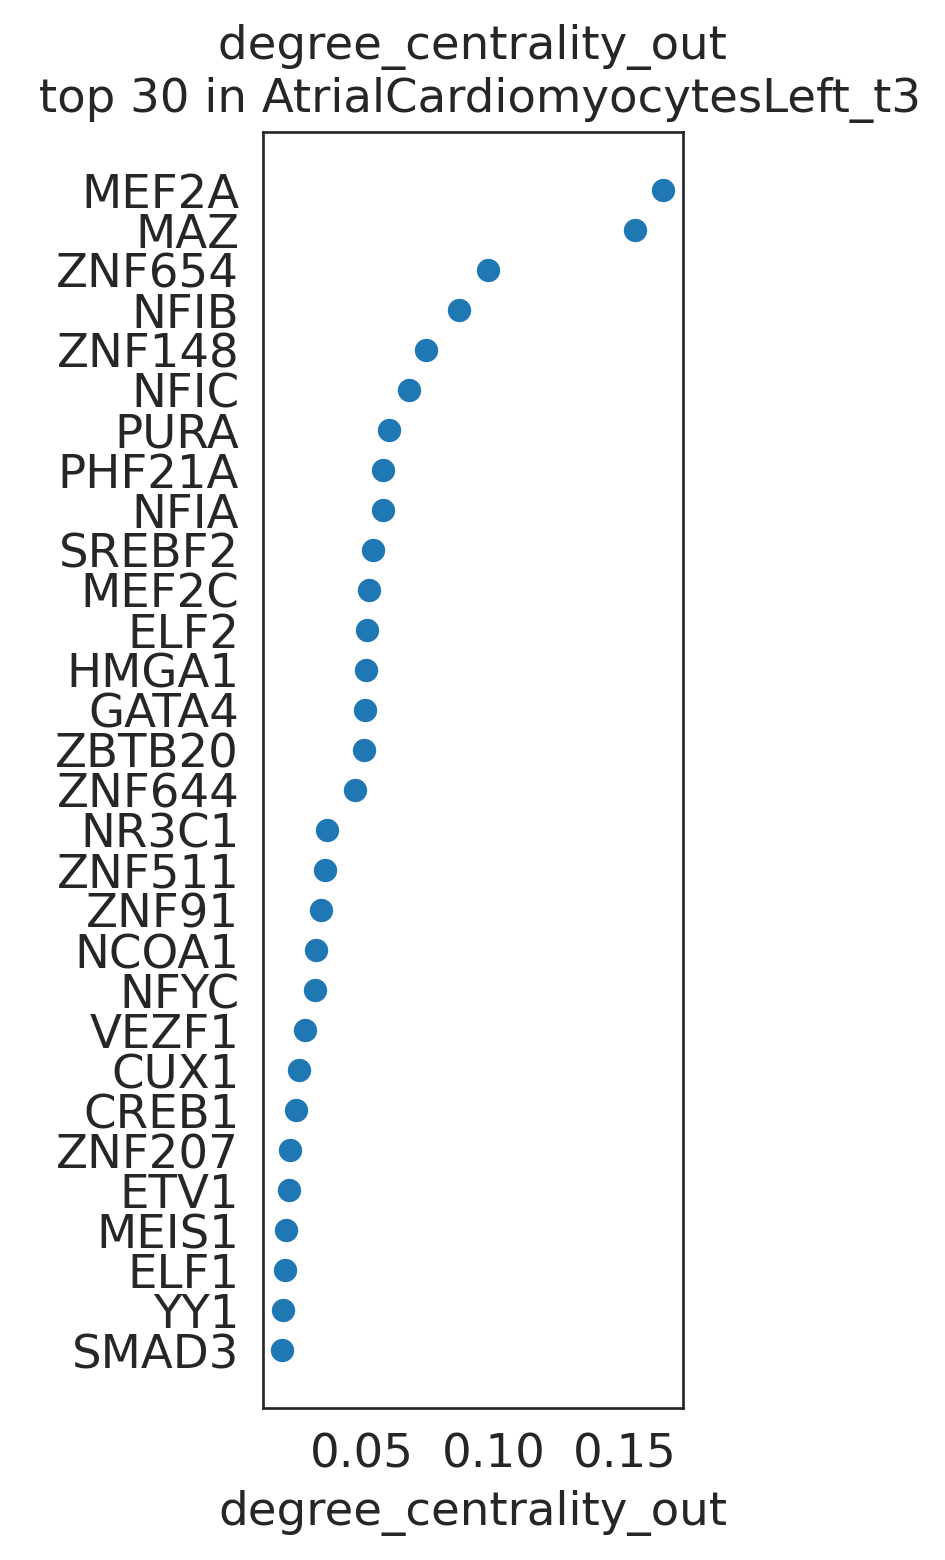

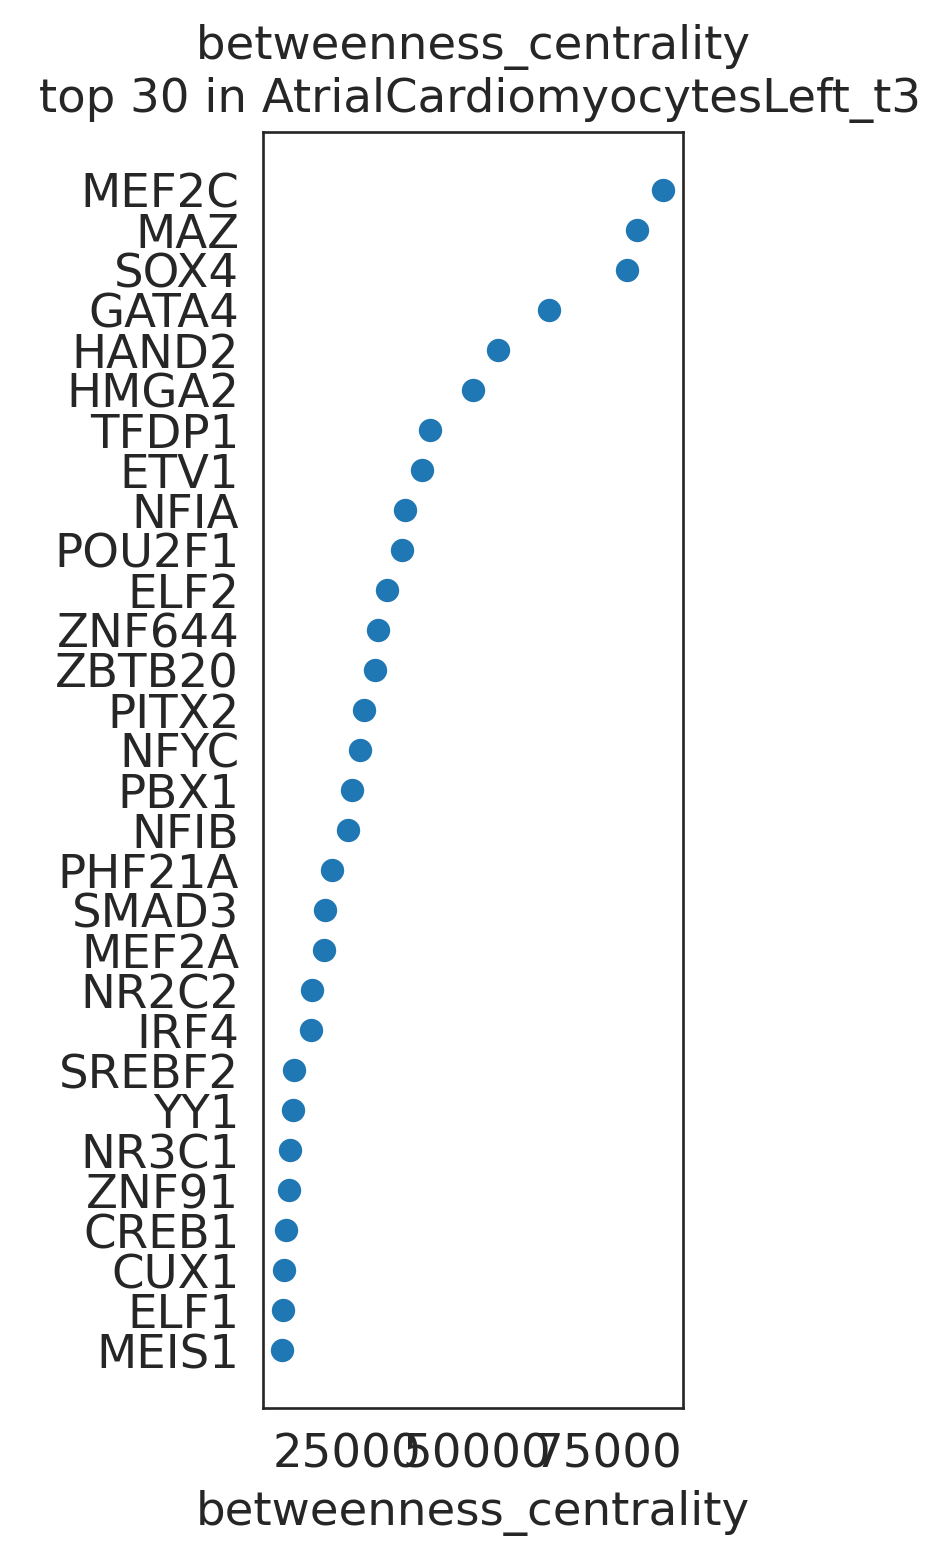

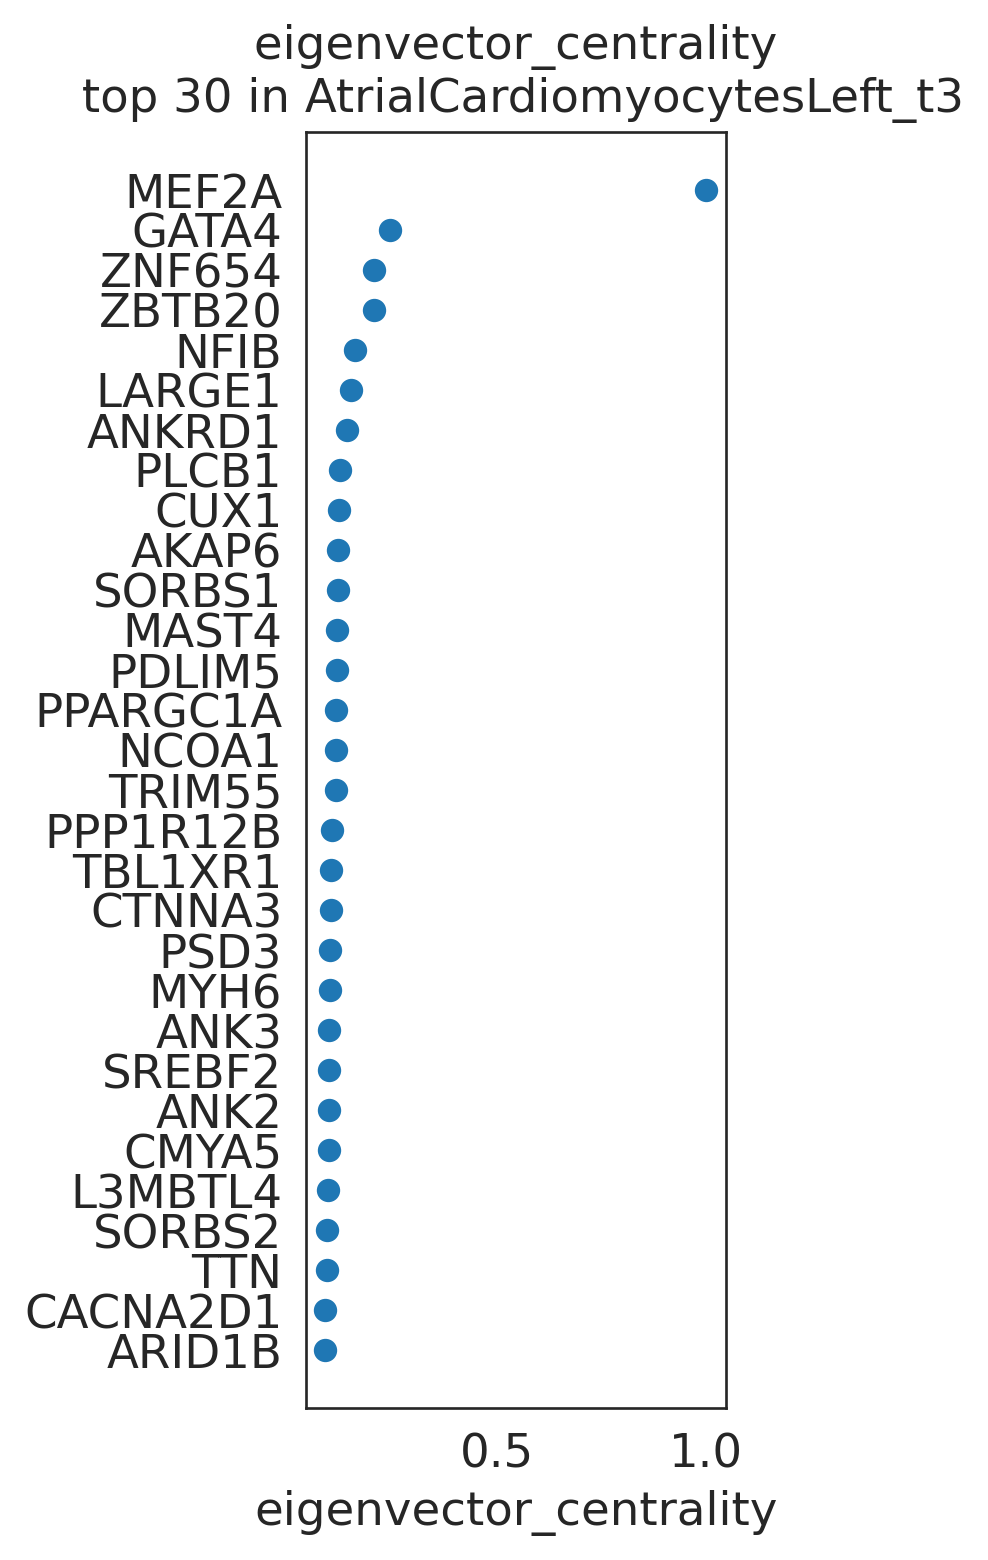

In [40]:
# Visualize top n-th genes with high scores.
plt.rcParams["figure.figsize"] = [5, 7]
links.plot_scores_as_rank(cluster='AtrialCardiomyocytesLeft_t3', n_gene=30, save=None)

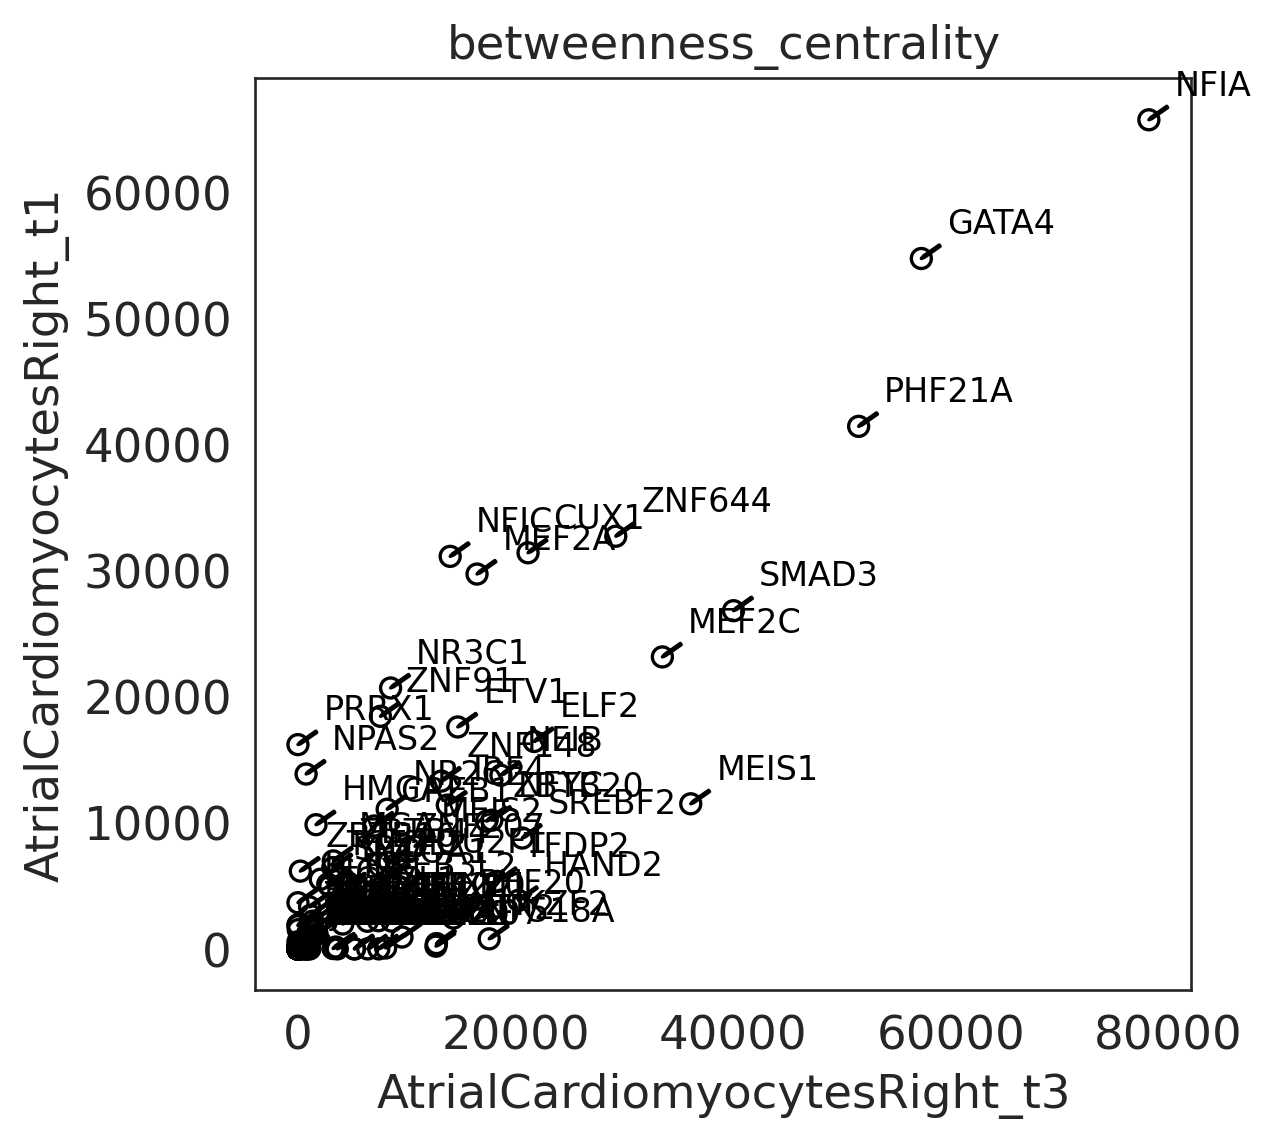

In [41]:
# Compare GRN score between two clusters
plt.rcParams["figure.figsize"] = [5, 5]
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1='AtrialCardiomyocytesRight_t3', cluster2='AtrialCardiomyocytesRight_t1',
                               percentile=98,
                               save=None)

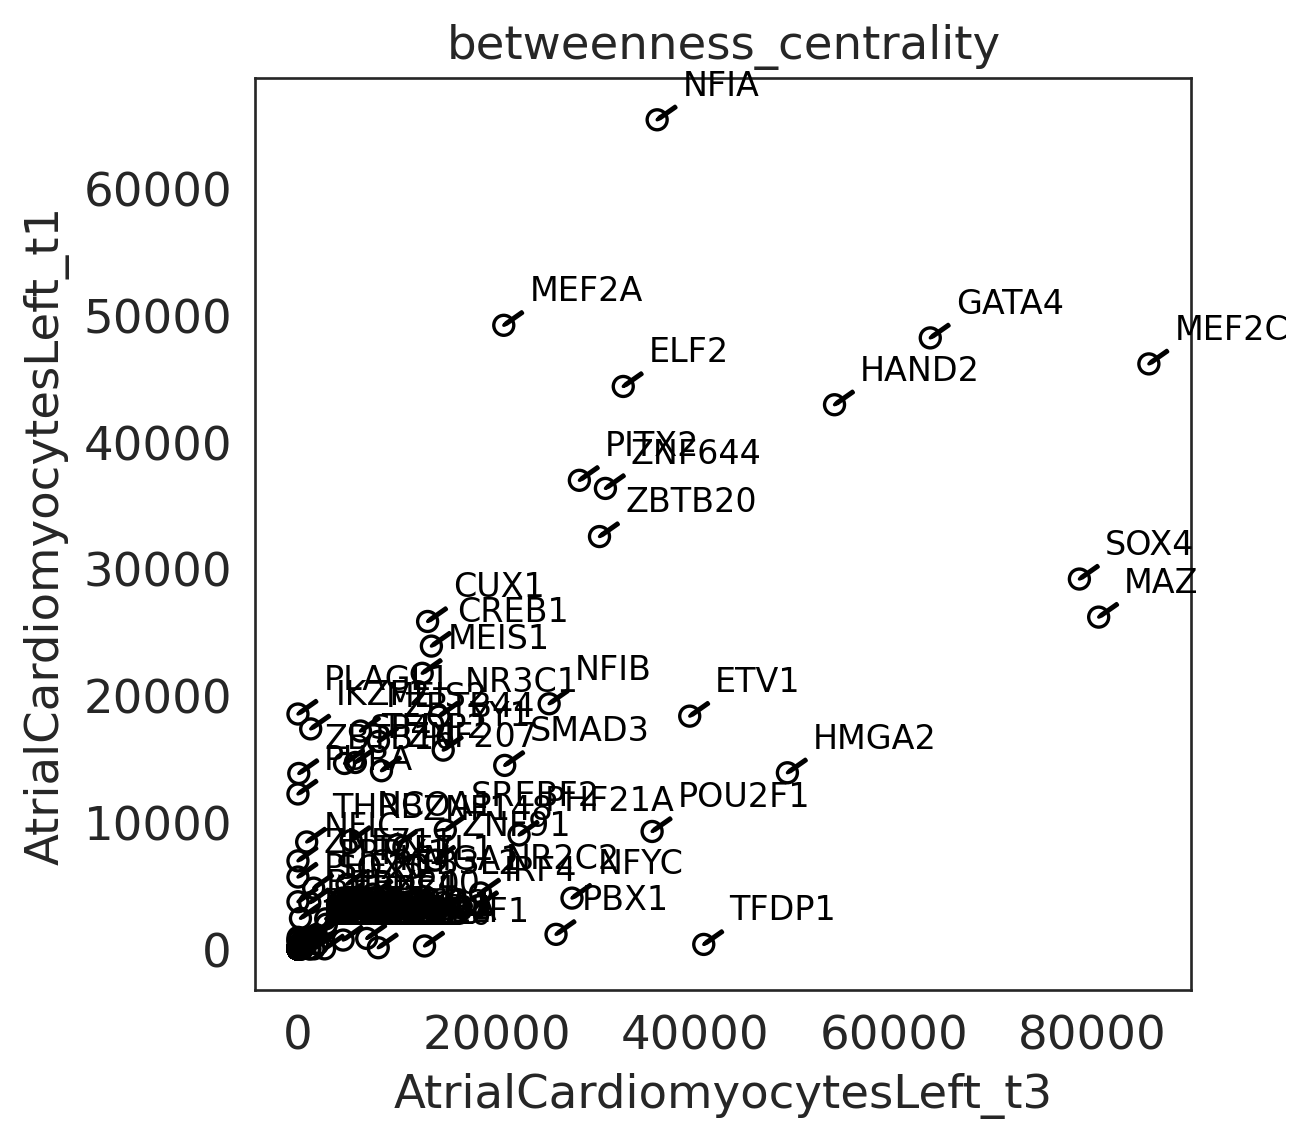

In [42]:
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1='AtrialCardiomyocytesLeft_t3', cluster2='AtrialCardiomyocytesLeft_t1',
                               percentile=98,
                               save=None)

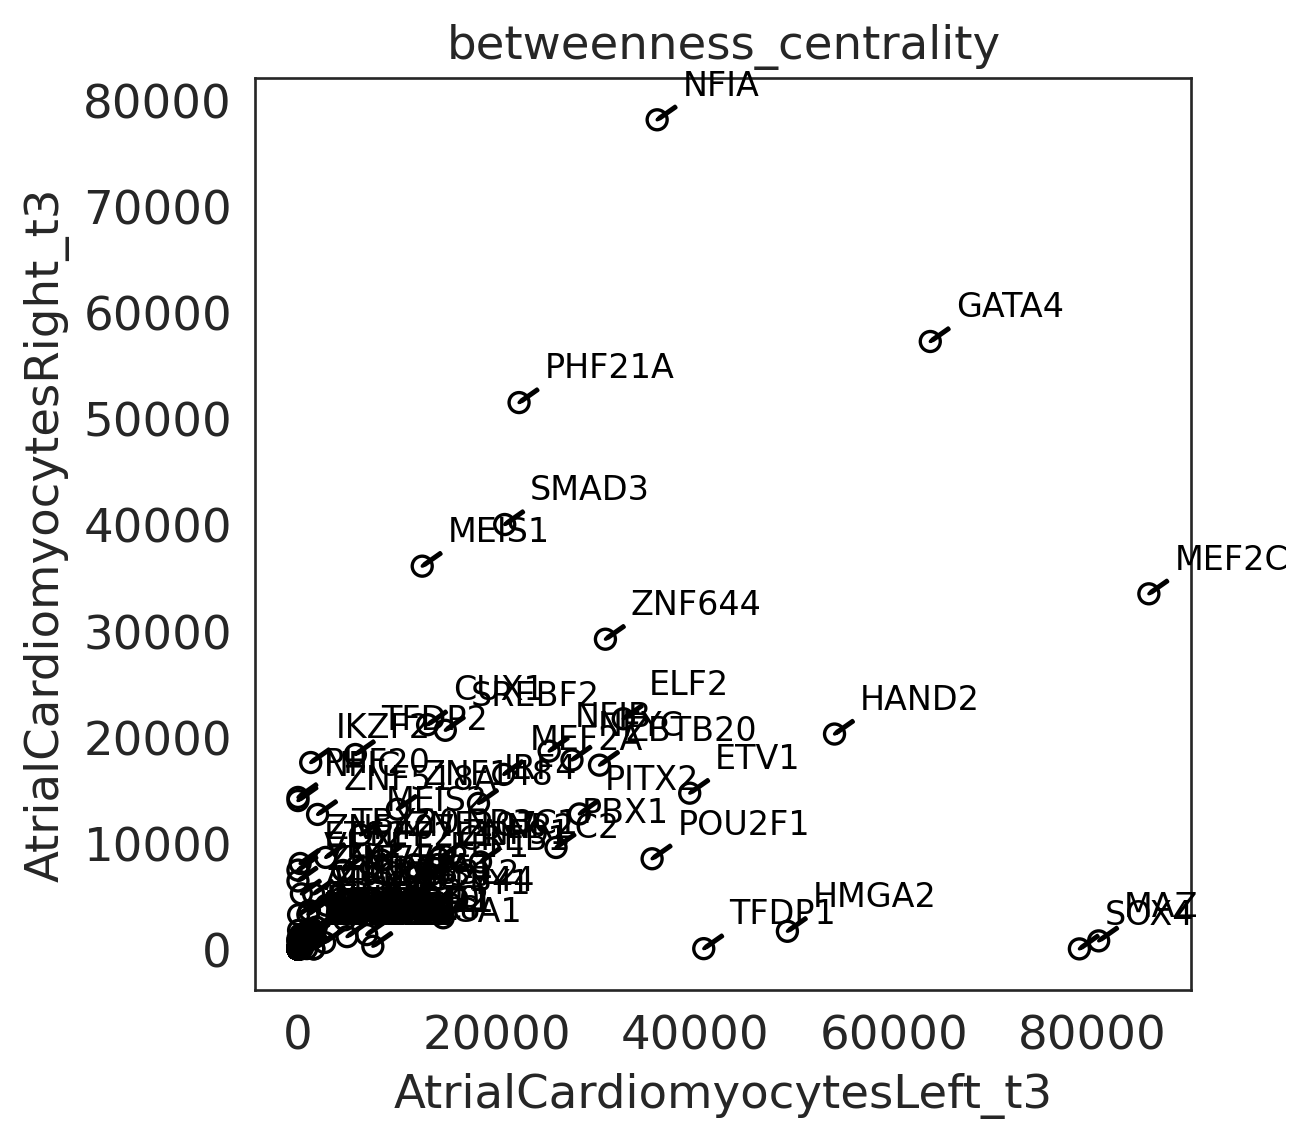

In [43]:
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1='AtrialCardiomyocytesLeft_t3', cluster2='AtrialCardiomyocytesRight_t3',
                               percentile=98,
                               save=None)

# Find parameters for n_grid and min_mass for perturbation simulation

from below</br>
ref: https://morris-lab.github.io/CellOracle.documentation/notebooks/05_simulation/Gata1_KO_simulation_with_Paul_etal_2015_data.html

In [44]:
# set a gene for this trial
goi = "PITX2"
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0}, # this is KO simulation so expression=0
                      n_propagation=3)

In [ ]:
%%time
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [ ]:
# visualisation
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 20
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

In [ ]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

In [ ]:
min_mass = 0.011
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

# Make predictive modelos for simulation

Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [ ]:
%%time
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

# In silico TF perturbation analysis

In [ ]:
# Check gene expression
goi = "TBX20"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

In [ ]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [ ]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0}, # this is KO simulation so expression=0
                      n_propagation=3)

The next step calculates the probability of cell state transitions based on the simulation data. You can use the transition probabilities between cells to predict how cells will change after a perturbation.

This transition probability will be used later.

In [ ]:
%%time
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# Visualisation

**Caution: It is very important to find the optimal scale parameter.**

If the vectors are not visible, you can try a smaller scale parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means that the scale parameter is too small.

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 20
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

## Find parameters for n_grid and min_mass

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

In [ ]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

In [ ]:
min_mass = 0.011
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

## Plot vector field

Again, we need to adjust the scale parameter. Please seek to find the optimal scale parameter that provides good visualization.

If you don’t see any vector, you can try the smaller scale parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means the scale parameter is too small.

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.1
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()


In [ ]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

# Compare simulation vector with development vectors

Here, we will calculate the development vector field using pseudotime gradient as follows.

1. Transfer the pseudotime data into an n x n digitized grid.
2. Calculate the 2D gradient of pseudotime to get vector field.
3. Compare the in silico TF perturbation vector field with the development vector field by calculating inner product between these two vectors.

Note: Other methods may be used to represent a continuous scRNA-seq trajectory flow. For example, RNA velocity analysis is a good way to estimate the direction of cell differentiation. Choose the method that best suits your data.

In the analysis below, we will use pseudotime data. Pseudotime data is included in the demo data. If you are analyzing your own scRNA-seq data, please calculate pseudotime before starting this analysis.



In [ ]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["t"])

In [ ]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="t")

In [ ]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

Next, we convert the pseudotime data into grid points. For this calculation we can chose one of two methods.

knn: K-Nearesr Neighbor regression. You will need to set number of neighbors. Please adjust n_knn for best results.This will depend on the population size and density of your scRNA-seq data.

gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})

polynomial: Polynomial regression using x-axis and y-axis of dimensional reduction space.

In general, this method will be more robust. Please use this method if knn method does not work. n_poly is the number of degrees for the polynomial regression model. Please try to find appropriaten_poly searching for best results.

gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3})

In [ ]:
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})

Calculate the 2D vector map to represents the pseudotime gradient. After the gradient calculation, the length of the vector will be normalized automatically.

Please adjust the scale parameter to adjust vector length visualization.

In [ ]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

In [ ]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

The inner product represents the similarity between two vectors.

Using the inner product, we compare the 2D vector field of perturbation simulation and development flow.

The inner product will be a positive value when two vectors are pointing in the same direction.

Conversely, the inner product will be a negative value when two vectors are pointing in the opposing directions.

The length of the vectors also affects the magnitude of inner product value.

In summary, we quantitatively compare the directionality and size of vectors between perturbation simulation and natural differentiation using inner product, and we define the score as perturbation score (PS).

A negative PS means that the TF perturbation would block differentiation.

A positive PS means that the TF perturbation would promote differentiation.



In [ ]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

Here, need to adjust the vm parameter for the PS score color visualization. Please seek to find the optimal vm parameter that provides good visualization.

If you don’t see any color in the left panel below, you can try the smaller vm parameter to magnify the scale of vm visualization. However, if you see colors in the randomized results (right panel), it means the vm parameter is too small.

In [ ]:
# Show perturbation scores
vm = 0.01

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax[0])
ax[0].set_title(f"PS")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS calculated with Randomized simulation vector")
plt.show()

In [ ]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

In [ ]:
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=vm)

In [ ]:
dev.inner_product_df

In [ ]:
dev.cell_idx_use

In [ ]:
dir(dev)

# Focus on a single development lineage to interpret the results in detail

In [ ]:
# Get cell index list for the cells of interest
clusters = ['VentricularCardiomyocytesLeftCompact_t1',
 'VentricularCardiomyocytesLeftCompact_t2',
 'VentricularCardiomyocytesLeftCompact_t3']
cell_idx = np.where(oracle.adata.obs["fine_grain_time-binned"].isin(clusters))[0]

# Check index
print(cell_idx)

In [ ]:
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle,
                                 cell_idx_use=cell_idx, # Enter cell id list
                                 name="Lineage_Compact" # Name of this cell group. You can enter any name.
                                 )

# Calculation
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

In [ ]:
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=vm)

In [ ]:
dev.inner_product_df

In [ ]:
dev

In [ ]:
df = dev.inner_product_df.copy()
df[['score','pseudotime']].corr(method='pearson')

In [ ]:
dir(dev)

In [ ]:
dev.inner_product_df

In [ ]:
len(dev.inner_product)